In [2]:
#Decoding with SVM averaged over 100 random seeds
#Decoding of 500 days of Summer vs other movies (only 2 classes)

In [ ]:
import os
import glob
import time 
import copy
import pickle
import random
import sklearn
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
from sklearn.inspection import permutation_importance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, roc_curve, auc, plot_confusion_matrix
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from mlxtend.plotting import plot_decision_regions

import utils.helper_func as hf
import utils.plotting as plotting
import utils.decoding as decoding

warnings.filterwarnings("ignore")

In [2]:
patient_id = 46
session_nr = 1

#top_dir = '/media/alado/TOSHIBA_EXT/thesis/output'
top_dir = '/home/anastasia/epiphyte/anastasia/output'
folder = f'05-Hilbert_transform_{patient_id}'
filtering_type = ['theta', 'slow_gamma', 'fast_gamma']

fs = 32768
#The resulting sample rate is up / down times the original sample rate.
up = 1
down=32
fs_downs = (up/down)*fs
dt = 1/fs_downs      # sampling period/time/interval or time resolution, often denoted as T

times = np.linspace(-500, 1000, num = 1501)
time_zero_idx = np.where(times == hf.find_nearest(times, 0))[0][0]

df_patient_info = pd.read_csv(f'{top_dir}/{patient_id}_channel_info.csv')
dict_replace = {'LA1':'LAA1', 'LA2':'LAA2', 'LA3':'LAA3', 'LA4':'LAA4', 'LA5':'LAA5', 'LA6':'LAA6', 'LA7':'LAA7', 'LA8':'LAA8',
               'RA1':'RAA1', 'RA2':'RAA2', 'RA3':'RAA3', 'RA4':'RAA4', 'RA5':'RAA5', 'RA6':'RAA6', 'RA7':'RAA7', 'RA8':'RAA8',}
df_patient_info_new = df_patient_info.replace(dict_replace)
df_stim_info = pd.read_csv(f'{top_dir}/{patient_id}_df_stim_info.csv')
all_stim = np.unique(df_stim_info['stim_id'])
all_stim_name = np.unique(df_stim_info['stim_name'])
all_brain_areas = np.unique(df_patient_info_new['recording_site'])
#brain_areas = ['LAA', 'LAH', 'LEC','LMH', 'LPHC', 'RAA', 'RAH', 'REC', 'RMH', 'RPHC']
brain_areas = np.unique(df_patient_info['brain_area'])

n_channels = 80
n_stim_present = 10
n_stim = 42

In [3]:
time_chunks = ['200_500', '500_800', '200_600', '400_800']
time_chunks_dict = {'200_500_st':700, '200_500_end':1000, '500_800_st':1000, '500_800_end':1300, 
                    '200_600_st':700, '200_600_end':1100,'400_800_st':900, '400_800_end':1300}
n_pca_comp = 10

columns_data_array = []
for j in filtering_type:
    for i in range(len(df_patient_info['channel_name'])):
        ch = df_patient_info.loc[i,'channel_name']
        ch_site = df_patient_info.loc[i,'recording_site']
        
        for tm in time_chunks:
            columns_data_array.append(f'{j}_{ch}_{tm}_mean')
            columns_data_array.append(f'{j}_{ch}_{tm}_median')
            columns_data_array.append(f'{j}_{ch}_{tm}_variance')
            columns_data_array.append(f'{j}_{ch}_{tm}_rms')
        
        for comp in range(n_pca_comp):
            columns_data_array.append(f'{j}_{ch}_pca_{comp+1}')

In [4]:
for i in range(len(df_patient_info['channel_name'])):
    ch = df_patient_info.loc[i,'channel_name']
    ch_site = df_patient_info.loc[i,'recording_site']
    
    path = f'{top_dir}/{folder}/theta/envelope/{ch}_{ch_site}'
    file_1 = f'{path}/{ch}_{ch_site}_38_???_amplitude_envelope_pre.npy'
    file_2 = f'{path}/{ch}_{ch_site}_38_unknown_amplitude_envelope_pre.npy'
    os.rename(file_1, file_2)

FileNotFoundError: [Errno 2] No such file or directory: '/home/anastasia/epiphyte/anastasia/output/05-Hilbert_transform_46/theta/envelope/CSC1_LA1/CSC1_LA1_38_???_amplitude_envelope_pre.npy' -> '/home/anastasia/epiphyte/anastasia/output/05-Hilbert_transform_46/theta/envelope/CSC1_LA1/CSC1_LA1_38_unknown_amplitude_envelope_pre.npy'

In [5]:
if os.path.isfile(f'{top_dir}/06-decoding_{patient_id}/df_data_post.csv'):
    df_data_post = pd.read_csv(f'{top_dir}/06-decoding_{patient_id}/df_data_post.csv')
    df_stimuli = pd.read_csv(f'{top_dir}/06-decoding_{patient_id}/df_stimuli.csv')
else:
    n_pca_components = 10
    df_data_pre = decoding.create_data_df(df_stim_info, df_patient_info, all_stim, filtering_type, time_chunks, time_chunks_dict, columns_data_array, folder, n_pca_components, 'pre', pca_mode=True)
    df_data_post, df_stimuli = decoding.create_data_df(df_stim_info, df_patient_info, all_stim, filtering_type, time_chunks, time_chunks_dict, columns_data_array, folder, n_pca_components, 'post', pca_mode=True)
    df_data_post.to_csv(f'{top_dir}/06-decoding_{patient_id}/df_data_post.csv')
    df_stimuli.to_csv(f'{top_dir}/06-decoding_{patient_id}/df_stimuli.csv')

In [6]:
#percentage of stimuli
#movie vs non-movie
arr = [brain_areas[:5], brain_areas[5:]]
movie_stim = df_stimuli['is_500_days'].sum() / 10
movie_stim_percentage = (movie_stim*100)/42
non_movie_stim_percentage = 100 - movie_stim_percentage
non_movie_stim_percentage

23.80952380952381

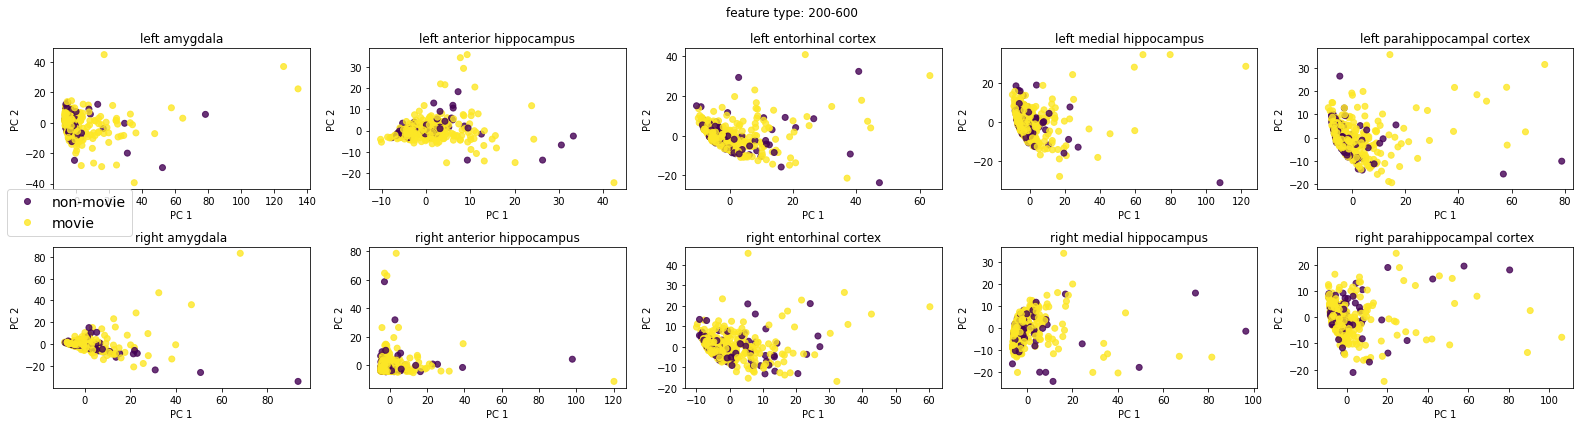

In [7]:
classes = ['non-movie', 'movie']
fig, axes = plt.subplots(2,5, figsize=(22,6))
feature_type = '200-600'
fig.suptitle(f'feature type: {feature_type}')
for a in range(len(arr)):
    br_areas = arr[a]
    for j in range(len(br_areas)):
        if a == 0:
            brain_area = brain_areas[j]
        else:
            brain_area = brain_areas[j+5]
        channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
        channel_cols = channel_cols.reset_index()
        cols_to_use = []
        for filt in filtering_type:
            for i in range(len(channel_cols)):
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_400_800') 
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_500')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')                
                #for k in range (1, n_pca_components+1):
                #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(k))

        #for multiclass one-vs-one: belongs to movie or not
        X = df_data_post[df_data_post.columns & cols_to_use]
        y = df_stimuli['is_500_days']

        #2D PCA scatter plot
        pca = PCA(n_components=2)
        components = pca.fit_transform(X)

        scatter = axes[a,j].scatter(components[:,0], components[:,1], c=df_stimuli['is_500_days'], alpha=0.8)
        axes[a,j].set_title(f'{brain_area}')
        axes[a,j].set_xlabel('PC 1')
        axes[a,j].set_ylabel('PC 2')
        handles, labels = scatter.legend_elements()
        labels = ['non-movie', 'movie']
        #axes[a,j].legend(handles, labels)

plt.tight_layout()
fig.legend(handles, labels, loc='center left', prop={'size': 14})
plt.show()
fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/data/post_data_PCA_{feature_type}.png', facecolor='white', transparent=False)

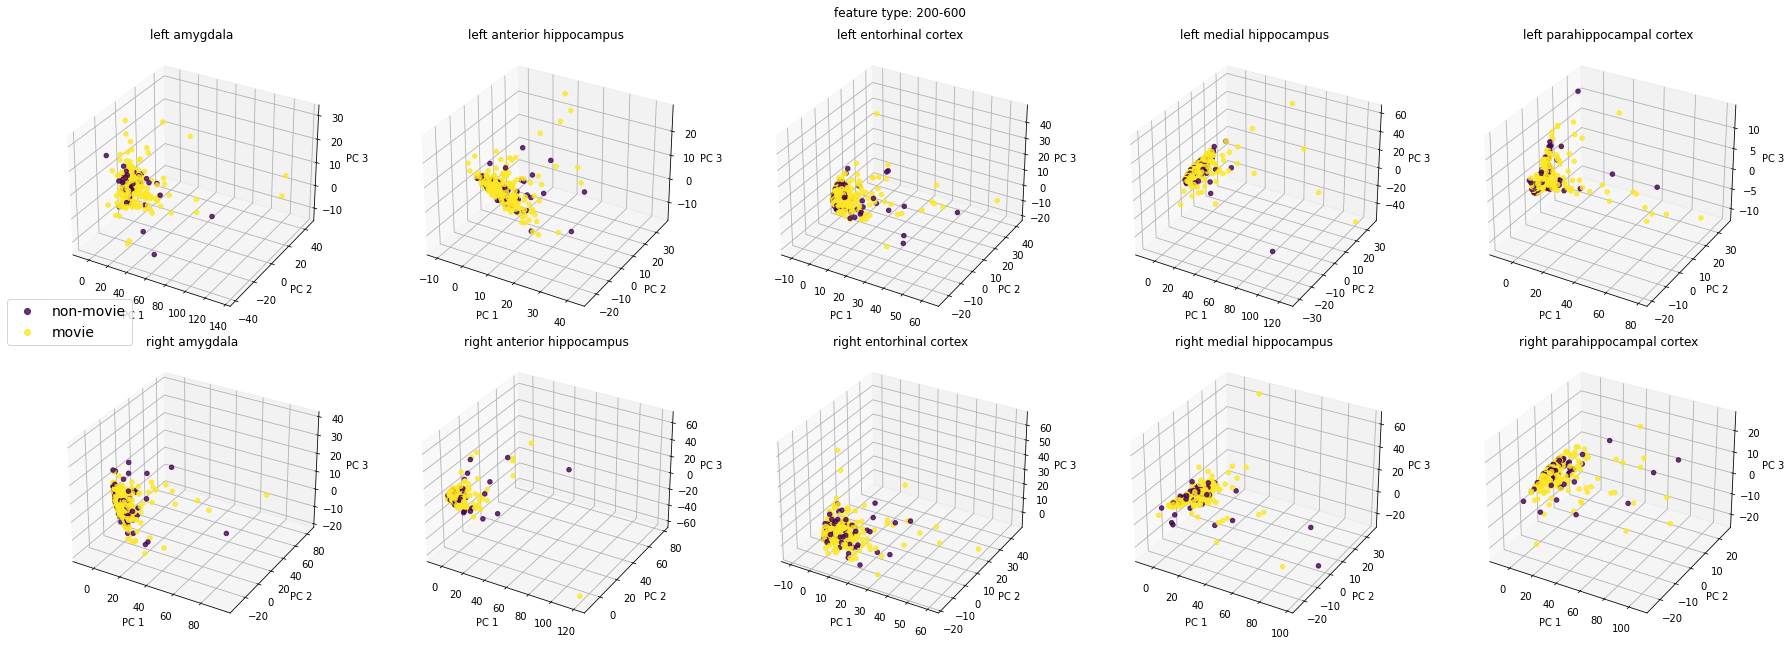

In [8]:
classes = ['non-movie', 'movie']
fig, axes = plt.subplots(2,5, figsize=(25,9), subplot_kw={"projection": "3d"})
feature_type = '200-600'
fig.suptitle(f'feature type: {feature_type}')
for a in range(len(arr)):
    br_areas = arr[a]
    for j in range(len(br_areas)):
        if a == 0:
            brain_area = brain_areas[j]
        else:
            brain_area = brain_areas[j+5]
        channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
        channel_cols = channel_cols.reset_index()
        cols_to_use = []
        for filt in filtering_type:
            for i in range(len(channel_cols)):
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_400_800') 
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_500')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')                 
                #for j in range (1, n_pca_components):
                #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

        #for multiclass one-vs-one: belongs to movie or not
        X = df_data_post[df_data_post.columns & cols_to_use]
        y = df_stimuli['is_500_days']

        #3D PCA scatter plot
        pca = PCA(n_components=3)
        components = pca.fit_transform(X)

        scatter = axes[a,j].scatter(components[:,0], components[:,1], components[:,2], c=df_stimuli['is_500_days'], alpha=0.8)
        axes[a,j].set_title(f'{brain_area}')
        axes[a,j].set_xlabel('PC 1')
        axes[a,j].set_ylabel('PC 2')
        axes[a,j].set_zlabel('PC 3')
        handles, labels = scatter.legend_elements()
        labels = ['non-movie', 'movie']
        #axes[a,j].legend(handles, labels)

plt.tight_layout()
fig.legend(handles, labels, loc='center left', prop={'size': 14})
plt.show()
fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/data/pre_data_PCA3_{feature_type}.png', facecolor='white', transparent=False)


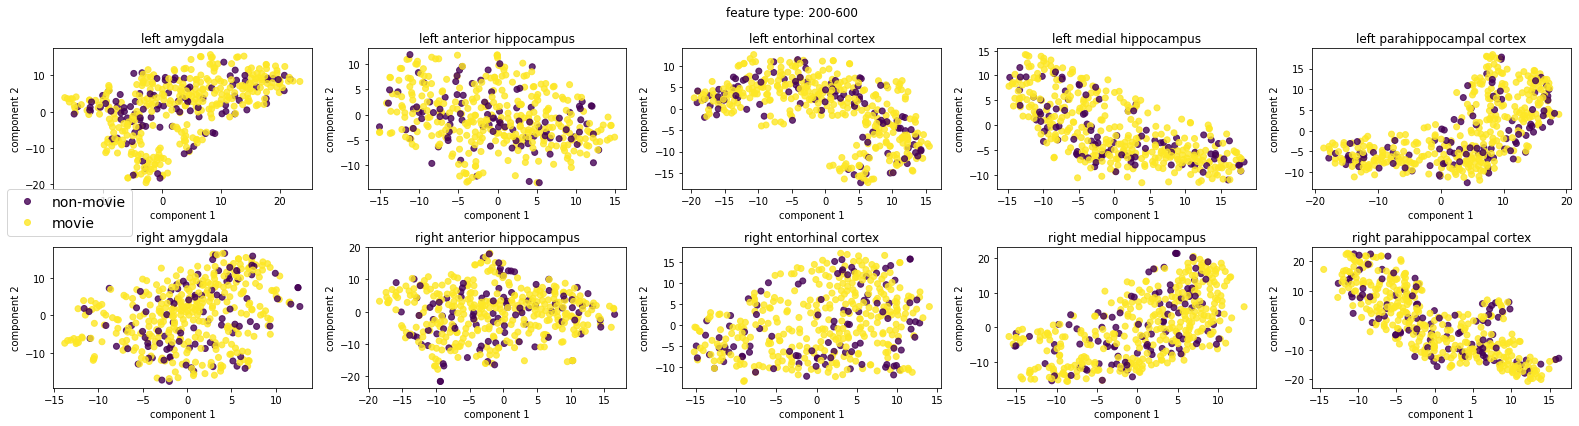

In [9]:
classes = ['non-movie', 'movie']
fig, axes = plt.subplots(2,5, figsize=(22,6))
feature_type = '200-600'
fig.suptitle(f'feature type: {feature_type}')
for a in range(len(arr)):
    br_areas = arr[a]
    for j in range(len(br_areas)):
        if a == 0:
            brain_area = brain_areas[j]
        else:
            brain_area = brain_areas[j+5]
        channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
        channel_cols = channel_cols.reset_index()
        cols_to_use = []
        for filt in filtering_type:
            for i in range(len(channel_cols)):
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_400_800') 
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_500')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')             
                #for j in range (1, n_pca_components):
                #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

        #for multiclass one-vs-one: belongs to movie or not
        X = df_data_post[df_data_post.columns & cols_to_use]
        y = df_stimuli['is_500_days']

        #2D t-SNE
        tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=5000)
        tsne_results = tsne.fit_transform(X)

        scatter = axes[a,j].scatter(tsne_results[:,0], tsne_results[:,1], c=df_stimuli['is_500_days'], alpha=0.8)
        axes[a,j].set_title(f'{brain_area}')
        axes[a,j].set_xlabel('component 1')
        axes[a,j].set_ylabel('component 2')
        handles, labels = scatter.legend_elements()
        labels = ['non-movie', 'movie']
        #axes[a,j].legend(handles, labels)

plt.tight_layout()
fig.legend(handles, labels, loc='center left', prop={'size': 14})
plt.show()
fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/data/post_data_tSNE_{feature_type}.png', facecolor='white', transparent=False)

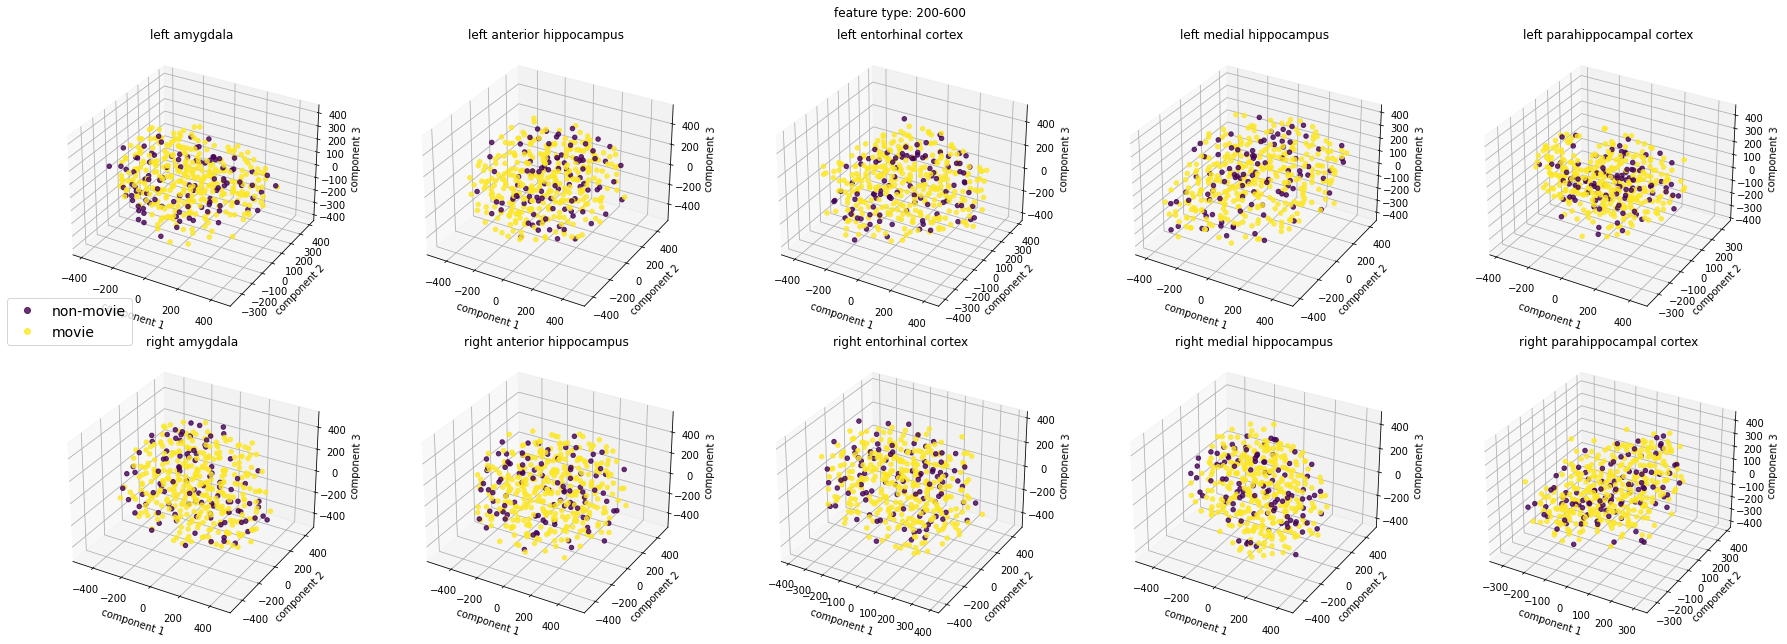

In [10]:
classes = ['non-movie', 'movie']
fig, axes = plt.subplots(2,5, figsize=(25,9), subplot_kw={"projection": "3d"})
feature_type = '200-600'
fig.suptitle(f'feature type: {feature_type}')
for a in range(len(arr)):
    br_areas = arr[a]
    for j in range(len(br_areas)):
        if a == 0:
            brain_area = brain_areas[j]
        else:
            brain_area = brain_areas[j+5]
        channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
        channel_cols = channel_cols.reset_index()
        cols_to_use = []
        for filt in filtering_type:
            for i in range(len(channel_cols)):
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_400_800') 
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_500')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')                 
                #for j in range (1, n_pca_components):
                #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

        #for multiclass one-vs-one: belongs to movie or not
        X = df_data_post[df_data_post.columns & cols_to_use]
        y = df_stimuli['is_500_days']

        #3D t-SNE scatter plot
        tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=5000)
        tsne_results = tsne.fit_transform(X)

        scatter = axes[a,j].scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], c=df_stimuli['is_500_days'], alpha=0.8)
        axes[a,j].set_title(f'{brain_area}')
        axes[a,j].set_xlabel('component 1')
        axes[a,j].set_ylabel('component 2')
        axes[a,j].set_zlabel('component 3')
        handles, labels = scatter.legend_elements()
        labels = ['non-movie', 'movie']
        #axes[a,j].legend(handles, labels)

plt.tight_layout()
fig.legend(handles, labels, loc='center left', prop={'size': 14})
plt.show()
fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/data/pre_data_tSNE3_{feature_type}.png', facecolor='white', transparent=False)

brain area: left amygdala
best classifier: [0.0001, 'hinge', 'l2', 'linear']
loss: 28.62
brain area: left anterior hippocampus
best classifier: [0.0005, 'poly']
loss: 30.53
brain area: left entorhinal cortex
best classifier: [0.0005, 'poly']
loss: 24.6
brain area: left medial hippocampus
best classifier: [0.0001, 'hinge', 'l2', 'linear']
loss: 29.81
brain area: left parahippocampal cortex
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
loss: 29.49
brain area: right amygdala
best classifier: [0.0005, 'poly']
loss: 20.37
brain area: right anterior hippocampus
best classifier: [0.01, 'poly']
loss: 20.49
brain area: right entorhinal cortex
best classifier: [0.1, 'poly']
loss: 23.08
brain area: right medial hippocampus
best classifier: [0.0005, 'poly']
loss: 22.93
brain area: right parahippocampal cortex
best classifier: [0.1, 'poly']
loss: 29.41
brain area: left amygdala
best classifier: [0.0001, 'hinge', 'l2', 'linear']
mean accuracy: 0.66±0.08
mean recall: 0.78±0.13
mean precisi

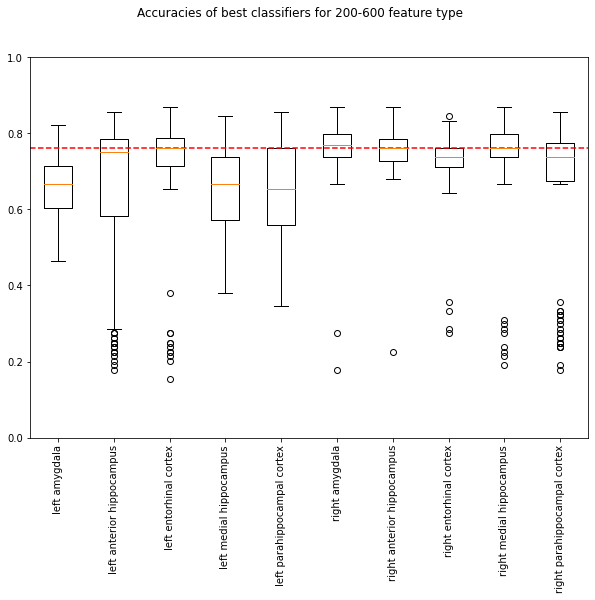

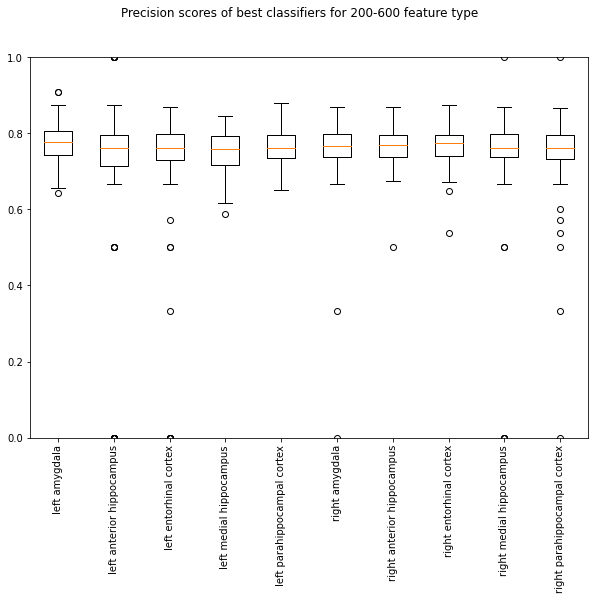

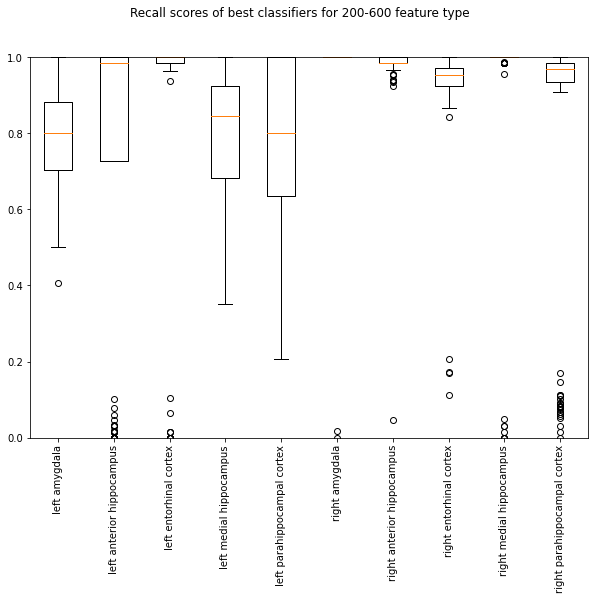

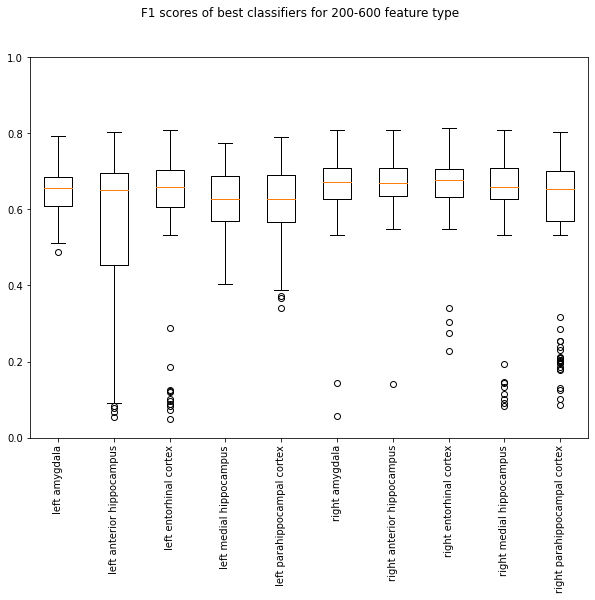

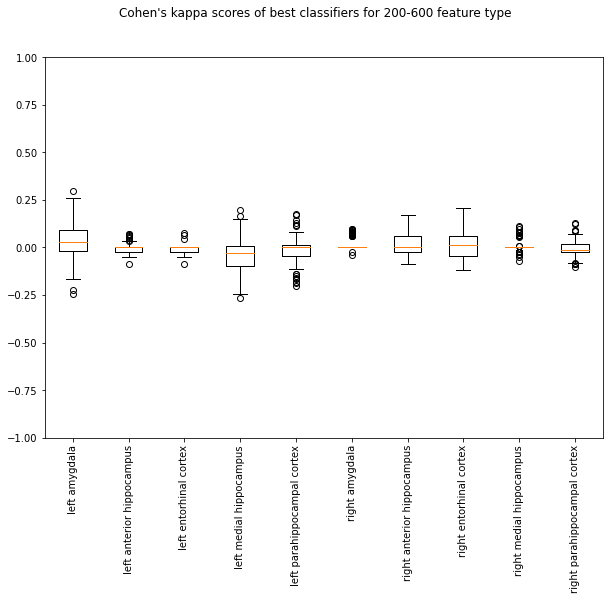

In [11]:
#NEW
#random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-600'

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')
            #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')            
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
        
    for rand_seed in random_seeds:
        np.random.seed(rand_seed) #for train-test split
        strings.append(rand_seed)
        best_params = {}

        # Use a K-fold cross validation with different parameters
        # Create all parameter combinations
        params = {'random_state': [rand_seed],
                  'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                  'loss': ['hinge', 'squared_hinge'],    
                  'penalty': ['l1', 'l2'],
                  #'gamma': ['scale', 'auto'],
                  #'degree': [3]
                 }
        # Create all possible parameter combinations
        combinations_linear = [[i, j, k, l] for i in params['random_state']
                       for j in params['C']
                       for k in params['loss']
                       for l in params ['penalty']]
        for s in reversed(combinations_linear):
            if (s[2] == 'hinge') and (s[3]=='l1'):
                combinations_linear.remove(s)
        combinations = [[i, j] for i in params['random_state']
                       for j in params['C']
                       #for l in params['gamma']
                       #for k in params['degree']
                       ]
        
        for kernel in kernels:
            if kernel == 'linear':
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations_linear, kernel, rand_seed, 'oversampling')
            else:
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations, kernel, rand_seed, 'oversampling') 
                
            all_losses.append([losses, brain_area])

params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}'
decoding.print_avg_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_precisions_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_recalls_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_f1s_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_kappas_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)

best_clfs = decoding.select_clf_lowest_loss(all_losses, comb_linear, comb_rest, kernels, brain_areas)

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}'
decoding.print_best_clfs_per_area(all_losses, best_clfs, brain_areas, feature_type, movie_stim_percentage, fig_save_path)

brain area: left amygdala
best classifier: [10, 'rbf']
loss: 40.07
brain area: left anterior hippocampus
best classifier: [0.0005, 'sigmoid']
loss: 39.74
brain area: left entorhinal cortex
best classifier: [0.01, 'sigmoid']
loss: 36.79
brain area: left medial hippocampus
best classifier: [10, 'sigmoid']
loss: 40.15
brain area: left parahippocampal cortex
best classifier: [10, 'rbf']
loss: 39.46
brain area: right amygdala
best classifier: [0.001, 'sigmoid']
loss: 41.41
brain area: right anterior hippocampus
best classifier: [0.001, 'sigmoid']
loss: 41.96
brain area: right entorhinal cortex
best classifier: [10, 'sigmoid']
loss: 40.72
brain area: right medial hippocampus
best classifier: [0.001, 'sigmoid']
loss: 39.06
brain area: right parahippocampal cortex
best classifier: [0.0005, 'rbf']
loss: 38.91
brain area: left amygdala
best classifier: [10, 'rbf']
mean accuracy: 0.52±0.06
mean recall: 0.5±0.07
mean precision: 0.8±0.05
mean F1: 0.56±0.06
mean kappa: 0.07±0.09
brain area: left ant

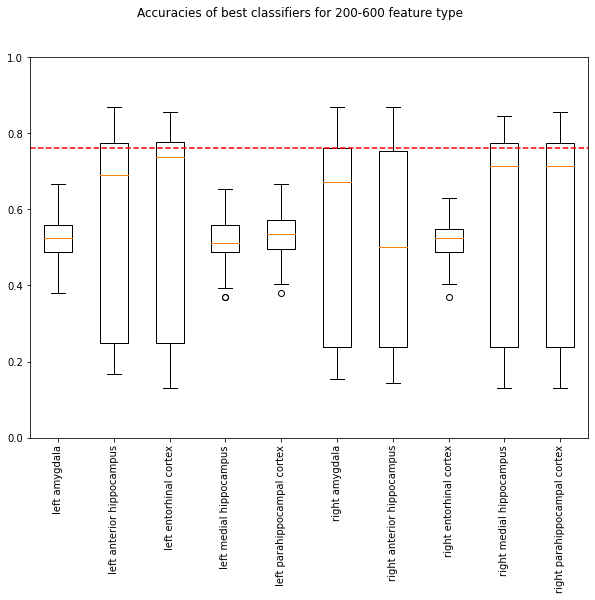

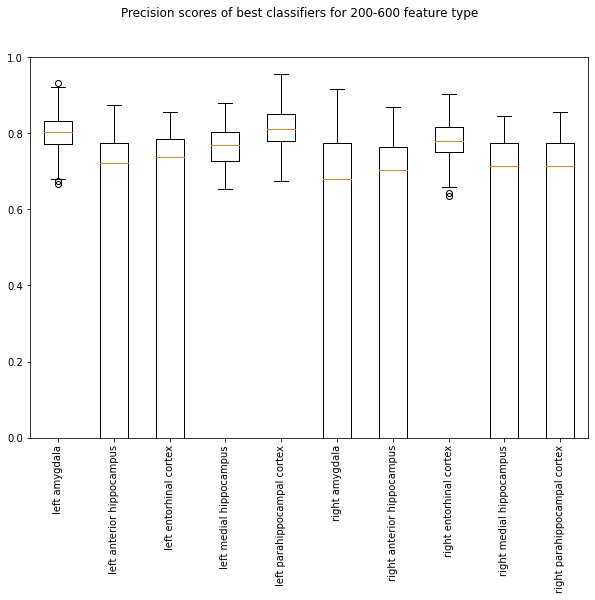

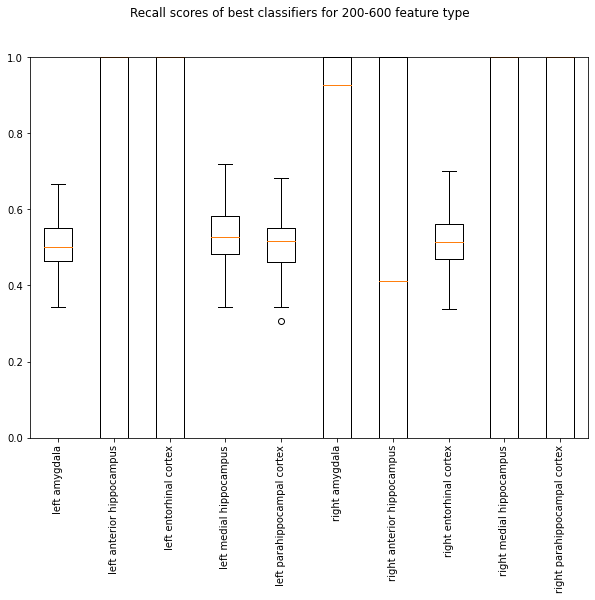

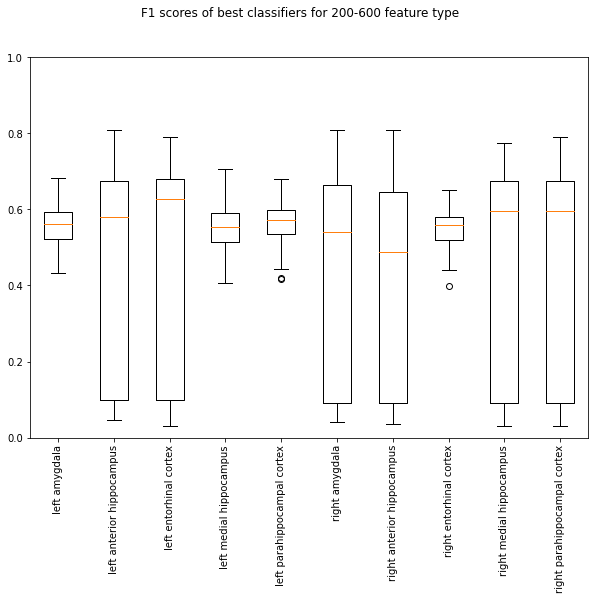

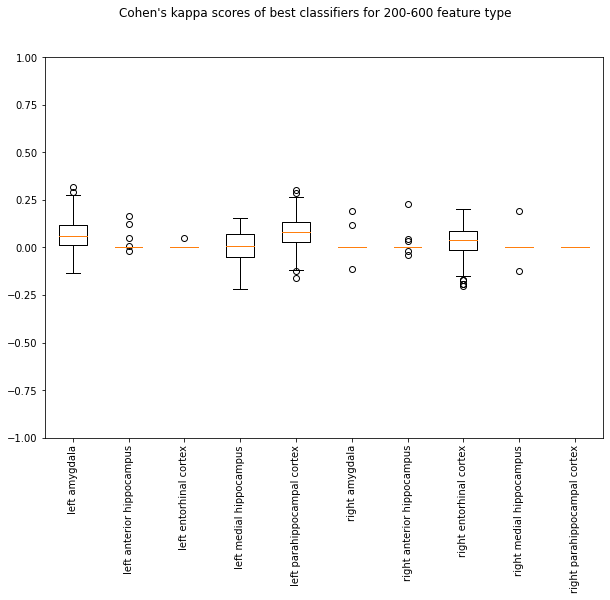

In [12]:
#NEW
#random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-600'

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            #print(for_cols.loc[i,'channel_name'])
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')          
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
        
    for rand_seed in random_seeds:
        np.random.seed(rand_seed) #for train-test split
        strings.append(rand_seed)
        best_params = {}

        # Use a K-fold cross validation with different parameters
        # Create all parameter combinations
        params = {'random_state': [rand_seed],
                  'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                  'loss': ['hinge', 'squared_hinge'],    
                  'penalty': ['l1', 'l2'],
                  #'gamma': ['scale', 'auto'],
                  #'degree': [3]
                 }
        # Create all possible parameter combinations
        combinations_linear = [[i, j, k, l] for i in params['random_state']
                       for j in params['C']
                       for k in params['loss']
                       for l in params ['penalty']]
        for s in reversed(combinations_linear):
            if (s[2] == 'hinge') and (s[3]=='l1'):
                combinations_linear.remove(s)
        combinations = [[i, j] for i in params['random_state']
                       for j in params['C']
                       #for l in params['gamma']
                       #for k in params['degree']
                       ]
        
        for kernel in kernels:
            if kernel == 'linear':
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations_linear, kernel, rand_seed, 'SMOTEENN')
            else:
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations, kernel, rand_seed, 'SMOTEENN') 
                
            all_losses.append([losses, brain_area])

params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}'
decoding.print_avg_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_precisions_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_recalls_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_f1s_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_kappas_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)

best_clfs = decoding.select_clf_lowest_loss(all_losses, comb_linear, comb_rest, kernels, brain_areas)

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}'
decoding.print_best_clfs_per_area(all_losses, best_clfs, brain_areas, feature_type, movie_stim_percentage, fig_save_path)

brain area: left amygdala
best classifier: [10, 'rbf']
loss: 40.07
brain area: left anterior hippocampus
best classifier: [0.0005, 'sigmoid']
loss: 39.74
brain area: left entorhinal cortex
best classifier: [0.01, 'sigmoid']
loss: 36.79
brain area: left medial hippocampus
best classifier: [10, 'sigmoid']
loss: 40.15
brain area: left parahippocampal cortex
best classifier: [10, 'rbf']
loss: 39.46
brain area: right amygdala
best classifier: [0.001, 'sigmoid']
loss: 41.41
brain area: right anterior hippocampus
best classifier: [0.001, 'sigmoid']
loss: 41.96
brain area: right entorhinal cortex
best classifier: [10, 'sigmoid']
loss: 40.72
brain area: right medial hippocampus
best classifier: [0.001, 'sigmoid']
loss: 39.06
brain area: right parahippocampal cortex
best classifier: [0.0005, 'rbf']
loss: 38.91
brain area: left amygdala
best classifier: [10, 'rbf']
mean accuracy: 0.52±0.06
mean recall: 0.5±0.07
mean precision: 0.8±0.05
mean F1: 0.56±0.06
mean kappa: 0.07±0.09
brain area: left ant

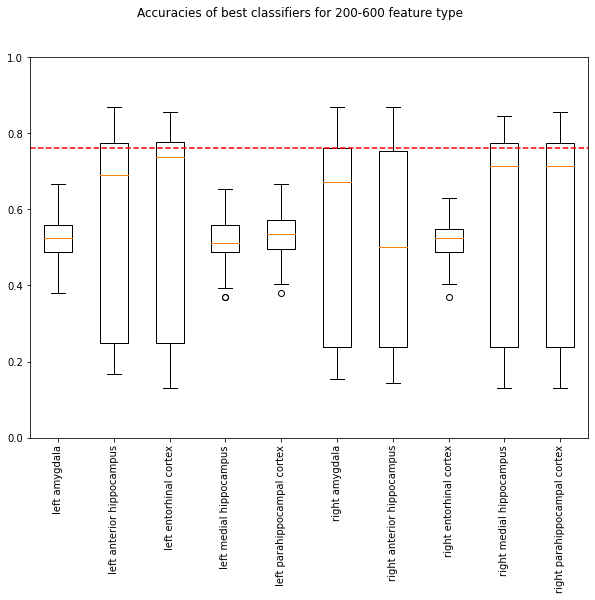

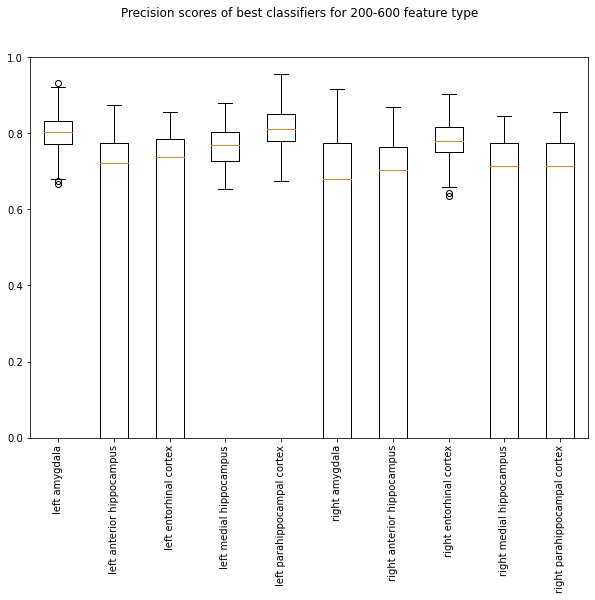

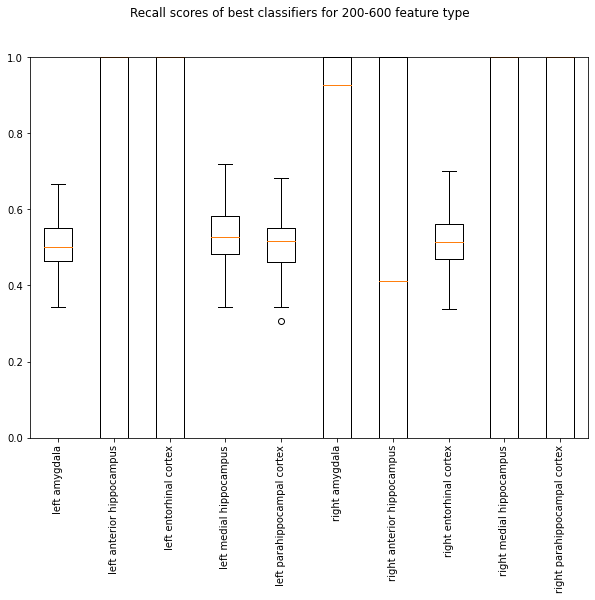

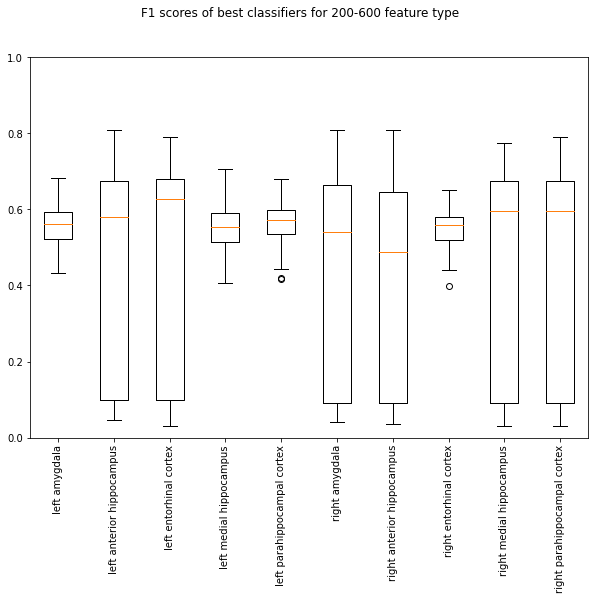

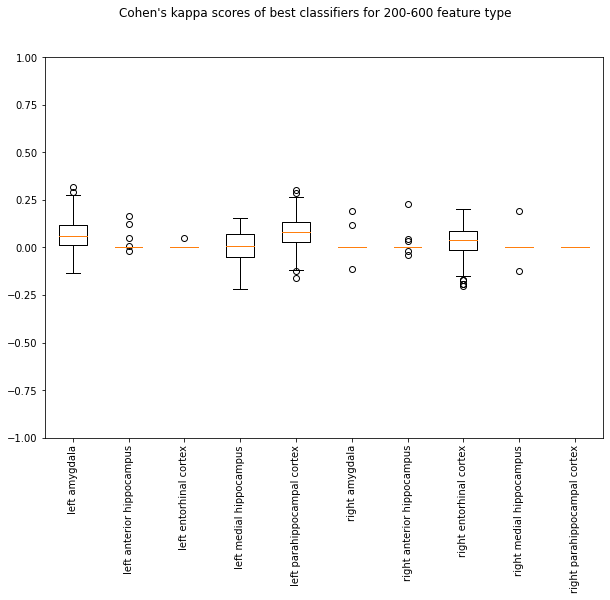

In [13]:
#NEW
#random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-600'

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            #print(for_cols.loc[i,'channel_name'])
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')            
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
        
    for rand_seed in random_seeds:
        np.random.seed(rand_seed) #for train-test split
        strings.append(rand_seed)
        best_params = {}

        # Use a K-fold cross validation with different parameters
        # Create all parameter combinations
        params = {'random_state': [rand_seed],
                  'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                  'loss': ['hinge', 'squared_hinge'],    
                  'penalty': ['l1', 'l2'],
                  #'gamma': ['scale', 'auto'],
                  #'degree': [3]
                 }
        # Create all possible parameter combinations
        combinations_linear = [[i, j, k, l] for i in params['random_state']
                       for j in params['C']
                       for k in params['loss']
                       for l in params ['penalty']]
        for s in reversed(combinations_linear):
            if (s[2] == 'hinge') and (s[3]=='l1'):
                combinations_linear.remove(s)
        combinations = [[i, j] for i in params['random_state']
                       for j in params['C']
                       #for l in params['gamma']
                       #for k in params['degree']
                       ]
        
        for kernel in kernels:
            if kernel == 'linear':
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations_linear, kernel, rand_seed, 'SMOTETomek')
            else:
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations, kernel, rand_seed, 'SMOTETomek') 
                
            all_losses.append([losses, brain_area])

params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}'
decoding.print_avg_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_precisions_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_recalls_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_f1s_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_kappas_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)

best_clfs = decoding.select_clf_lowest_loss(all_losses, comb_linear, comb_rest, kernels, brain_areas)

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}'
decoding.print_best_clfs_per_area(all_losses, best_clfs, brain_areas, feature_type, movie_stim_percentage, fig_save_path)

brain area: left amygdala
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
loss: 28.79
brain area: left anterior hippocampus
best classifier: [0.0001, 'hinge', 'l2', 'linear']
loss: 33.56
brain area: left entorhinal cortex
best classifier: [0.0005, 'poly']
loss: 30.79
brain area: left medial hippocampus
best classifier: [0.0001, 'hinge', 'l2', 'linear']
loss: 33.33
brain area: left parahippocampal cortex
best classifier: [0.0001, 'hinge', 'l2', 'linear']
loss: 30.53
brain area: right amygdala
best classifier: [0.0005, 'poly']
loss: 22.39
brain area: right anterior hippocampus
best classifier: [0.1, 'poly']
loss: 24.92
brain area: right entorhinal cortex
best classifier: [0.1, 'poly']
loss: 28.25
brain area: right medial hippocampus
best classifier: [0.0001, 'poly']
loss: 23.67
brain area: right parahippocampal cortex
best classifier: [10, 'poly']
loss: 33.77
brain area: left amygdala
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
mean accuracy: 0.66±0.2
mean recall: 0

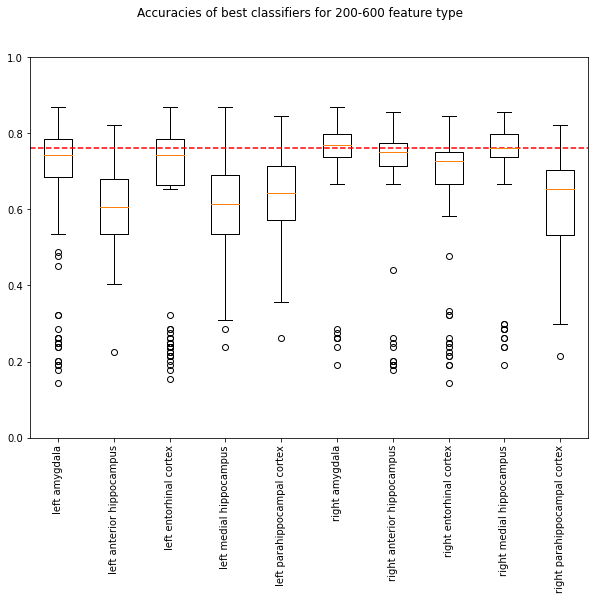

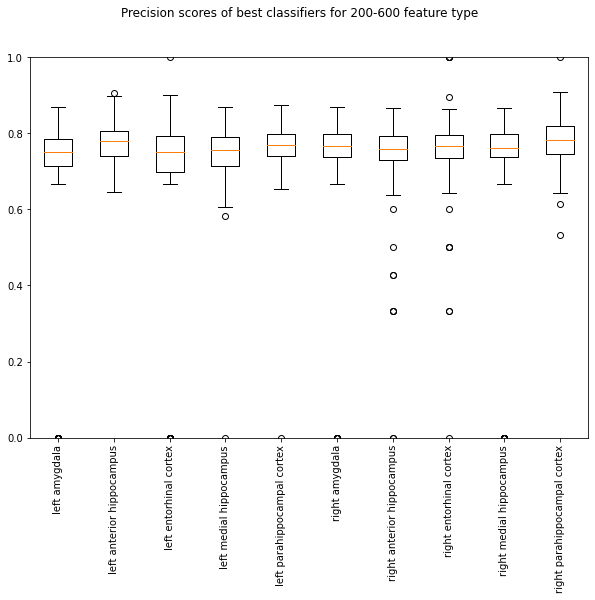

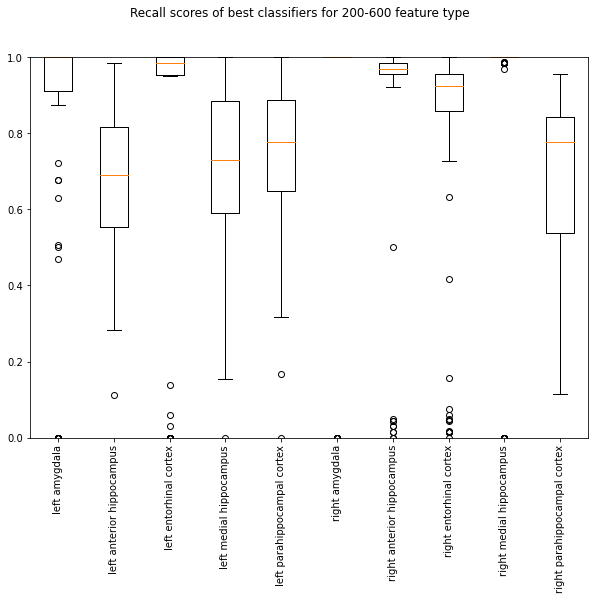

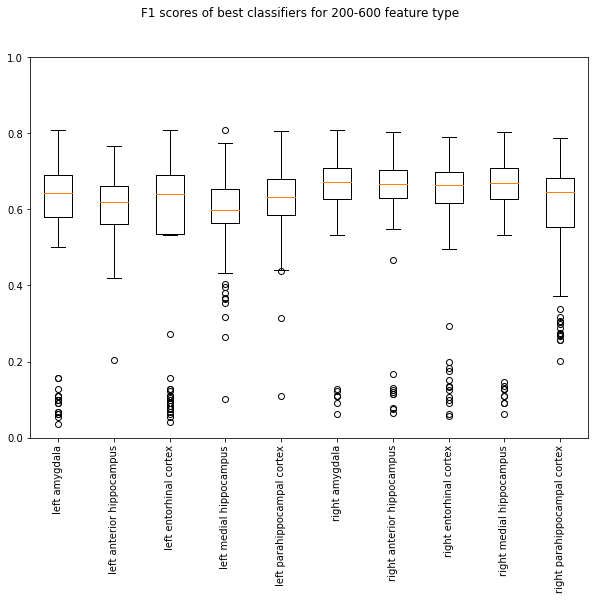

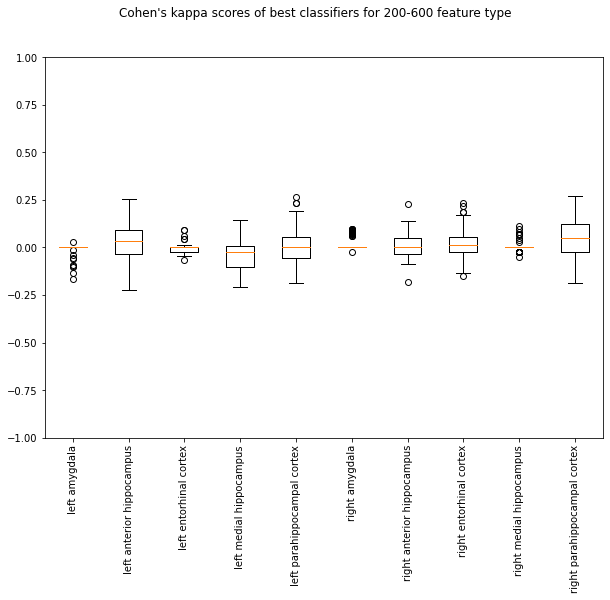

In [14]:
#NEW
#random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-600'

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            #print(for_cols.loc[i,'channel_name'])
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')          
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
        
    for rand_seed in random_seeds:
        np.random.seed(rand_seed) #for train-test split
        strings.append(rand_seed)
        best_params = {}

        # Use a K-fold cross validation with different parameters
        # Create all parameter combinations
        params = {'random_state': [rand_seed],
                  'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                  'loss': ['hinge', 'squared_hinge'],    
                  'penalty': ['l1', 'l2'],
                  #'gamma': ['scale', 'auto'],
                  #'degree': [3]
                 }
        # Create all possible parameter combinations
        combinations_linear = [[i, j, k, l] for i in params['random_state']
                       for j in params['C']
                       for k in params['loss']
                       for l in params ['penalty']]
        for s in reversed(combinations_linear):
            if (s[2] == 'hinge') and (s[3]=='l1'):
                combinations_linear.remove(s)
        combinations = [[i, j] for i in params['random_state']
                       for j in params['C']
                       #for l in params['gamma']
                       #for k in params['degree']
                       ]
        
        for kernel in kernels:
            if kernel == 'linear':
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations_linear, kernel, rand_seed, 'undersampling')
            else:
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations, kernel, rand_seed, 'undersampling') 
                
            all_losses.append([losses, brain_area])

params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}'
decoding.print_avg_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_precisions_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_recalls_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_f1s_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_kappas_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)

best_clfs = decoding.select_clf_lowest_loss(all_losses, comb_linear, comb_rest, kernels, brain_areas)

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}'
decoding.print_best_clfs_per_area(all_losses, best_clfs, brain_areas, feature_type, movie_stim_percentage, fig_save_path)

NameError: name 'item' is not defined

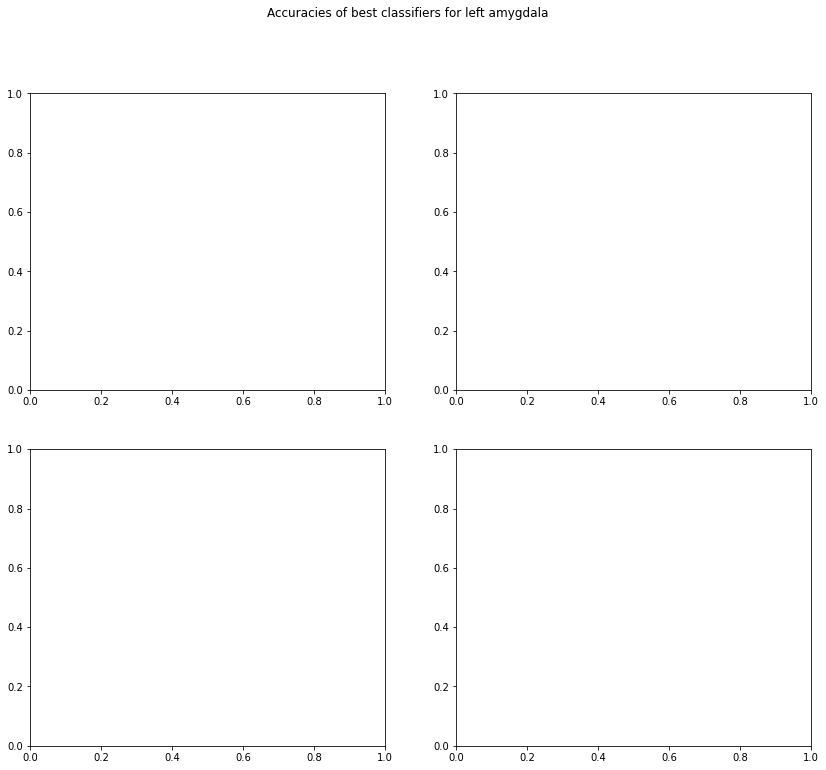

In [7]:
#NEW
#random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-600'

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            #print(for_cols.loc[i,'channel_name'])
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')            
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
        
    for rand_seed in random_seeds:
        np.random.seed(rand_seed) #for train-test split
        strings.append(rand_seed)
        best_params = {}

        # Use a K-fold cross validation with different parameters
        # Create all parameter combinations
        params = {'random_state': [rand_seed],
                  'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                  'loss': ['hinge', 'squared_hinge'],    
                  'penalty': ['l1', 'l2'],
                  #'gamma': ['scale', 'auto'],
                  #'degree': [3]
                 }
        # Create all possible parameter combinations
        combinations_linear = [[i, j, k, l] for i in params['random_state']
                       for j in params['C']
                       for k in params['loss']
                       for l in params ['penalty']]
        for s in reversed(combinations_linear):
            if (s[2] == 'hinge') and (s[3]=='l1'):
                combinations_linear.remove(s)
        combinations = [[i, j] for i in params['random_state']
                       for j in params['C']
                       #for l in params['gamma']
                       #for k in params['degree']
                       ]
        
        for kernel in kernels:
            if kernel == 'linear':
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations_linear, kernel, rand_seed, 'NearMiss')
            else:
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations, kernel, rand_seed, 'NearMiss') 
                
            all_losses.append([losses, brain_area])

params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}'
decoding.print_avg_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_balanced_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_precisions_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_recalls_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_f1s_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_kappas_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)

best_clfs = decoding.select_clf_lowest_loss(all_losses, comb_linear, comb_rest, kernels, brain_areas)

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}'
decoding.print_best_clfs_per_area(all_losses, best_clfs, brain_areas, feature_type, movie_stim_percentage, fig_save_path)

brain area: left amygdala
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
loss: 28.91
brain area: left anterior hippocampus
best classifier: [10, 'sigmoid']
loss: 42.86
brain area: left entorhinal cortex
best classifier: [0.01, 'poly']
loss: 22.34
brain area: left medial hippocampus
best classifier: [0.1, 'sigmoid']
loss: 35.62
brain area: left parahippocampal cortex
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
loss: 28.76
brain area: right amygdala
best classifier: [0.001, 'poly']
loss: 26.08
brain area: right anterior hippocampus
best classifier: [0.0005, 'poly']
loss: 21.76
brain area: right entorhinal cortex
best classifier: [0.01, 'poly']
loss: 23.87
brain area: right medial hippocampus
best classifier: [0.0001, 'poly']
loss: 26.07
brain area: right parahippocampal cortex
best classifier: [0.0001, 'poly']
loss: 23.23
brain area: left amygdala
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
mean accuracy: 0.66±0.17
mean recall: 0.8±0.3
mean precision: 

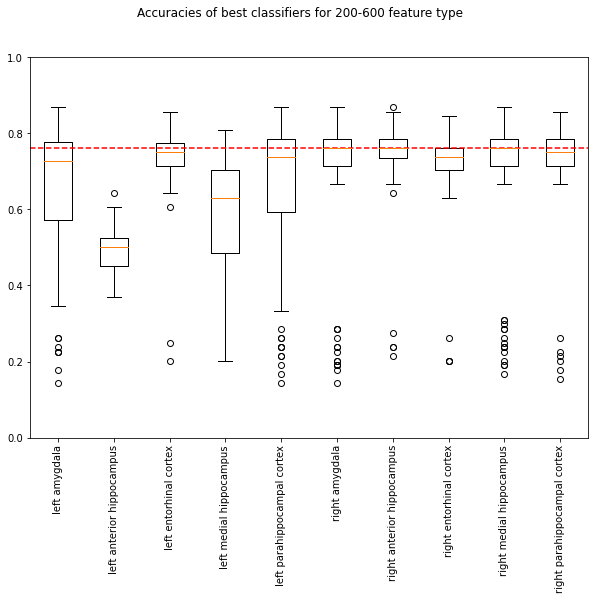

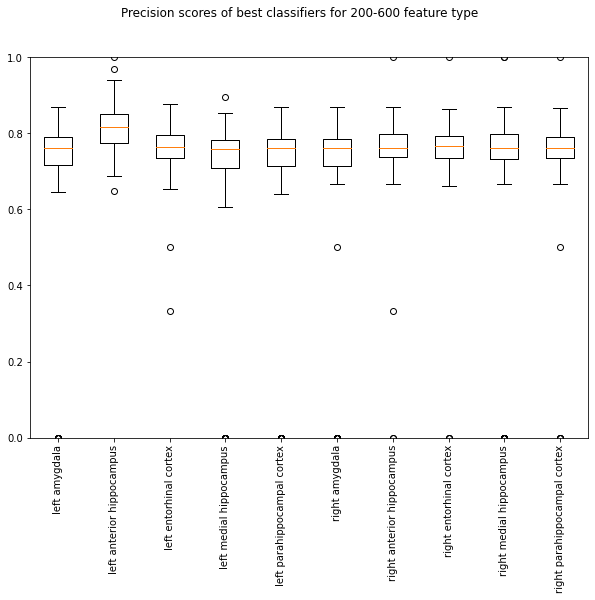

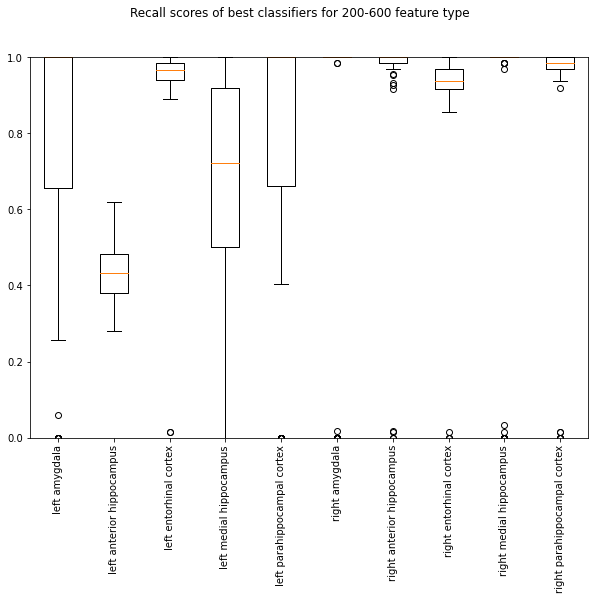

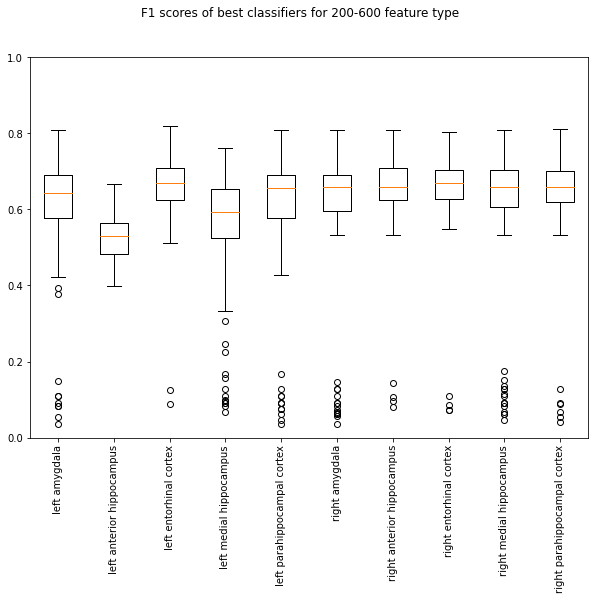

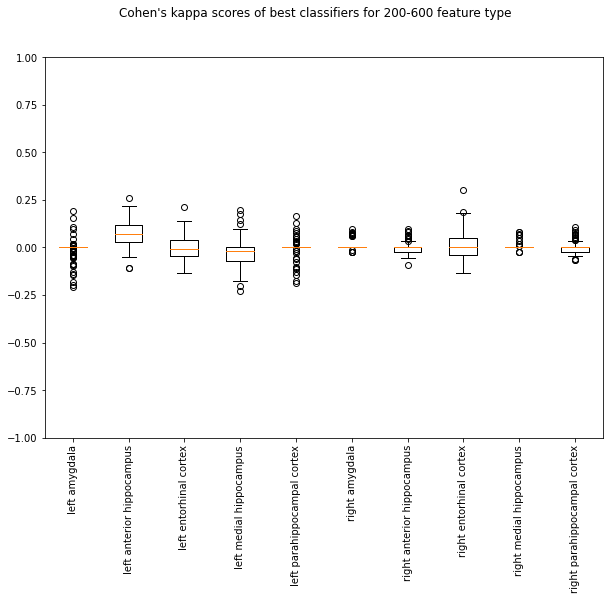

In [16]:
#NEW
#random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-600'

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            #print(for_cols.loc[i,'channel_name'])
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')            
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
        
    for rand_seed in random_seeds:
        np.random.seed(rand_seed) #for train-test split
        strings.append(rand_seed)
        best_params = {}

        # Use a K-fold cross validation with different parameters
        # Create all parameter combinations
        params = {'random_state': [rand_seed],
                  'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                  'loss': ['hinge', 'squared_hinge'],    
                  'penalty': ['l1', 'l2'],
                  #'gamma': ['scale', 'auto'],
                  #'degree': [3]
                 }
        # Create all possible parameter combinations
        combinations_linear = [[i, j, k, l] for i in params['random_state']
                       for j in params['C']
                       for k in params['loss']
                       for l in params ['penalty']]
        for s in reversed(combinations_linear):
            if (s[2] == 'hinge') and (s[3]=='l1'):
                combinations_linear.remove(s)
        combinations = [[i, j] for i in params['random_state']
                       for j in params['C']
                       #for l in params['gamma']
                       #for k in params['degree']
                       ]
        
        for kernel in kernels:
            if kernel == 'linear':
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations_linear, kernel, rand_seed, 'RepeatedNN')
            else:
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations, kernel, rand_seed, 'RepeatedNN') 
                
            all_losses.append([losses, brain_area])

params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}'
decoding.print_avg_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_precisions_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_recalls_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_f1s_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_kappas_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)

best_clfs = decoding.select_clf_lowest_loss(all_losses, comb_linear, comb_rest, kernels, brain_areas)

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}'
decoding.print_best_clfs_per_area(all_losses, best_clfs, brain_areas, feature_type, movie_stim_percentage, fig_save_path)

brain area: left amygdala
best classifier: [0.0001, 'hinge', 'l2', 'linear']
loss: 19.7
brain area: left anterior hippocampus
best classifier: [0.0001, 'hinge', 'l2', 'linear']
loss: 19.77
brain area: left entorhinal cortex
best classifier: [0.0001, 'hinge', 'l2', 'linear']
loss: 20.44
brain area: left medial hippocampus
best classifier: [0.0005, 'hinge', 'l2', 'linear']
loss: 19.69
brain area: left parahippocampal cortex
best classifier: [0.0001, 'hinge', 'l2', 'linear']
loss: 19.7
brain area: right amygdala
best classifier: [0.001, 'poly']
loss: 19.79
brain area: right anterior hippocampus
best classifier: [0.0001, 'hinge', 'l2', 'linear']
loss: 20.4
brain area: right entorhinal cortex
best classifier: [0.0001, 'hinge', 'l2', 'linear']
loss: 20.25
brain area: right medial hippocampus
best classifier: [0.001, 'hinge', 'l2', 'linear']
loss: 20.85
brain area: right parahippocampal cortex
best classifier: [0.0001, 'hinge', 'l2', 'linear']
loss: 21.56
brain area: left amygdala
best classi

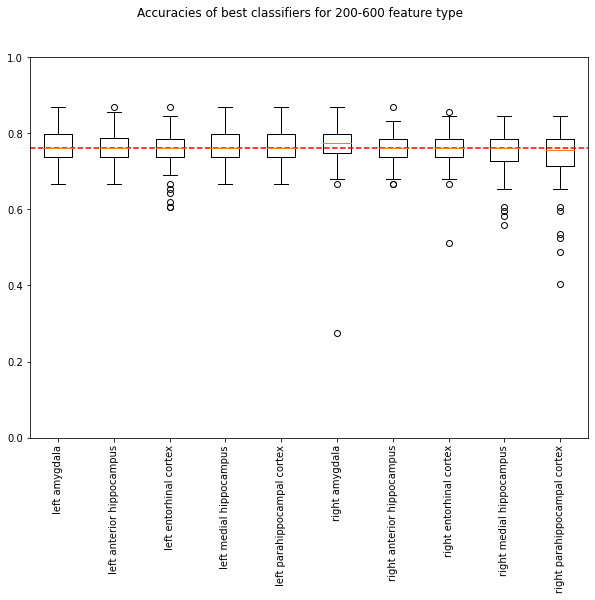

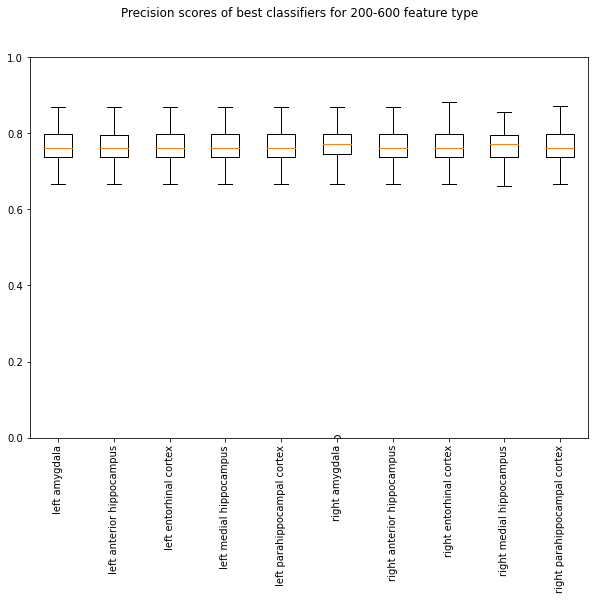

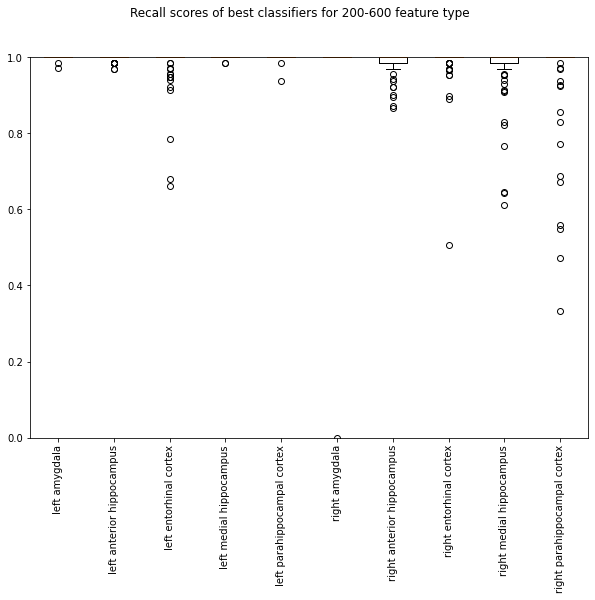

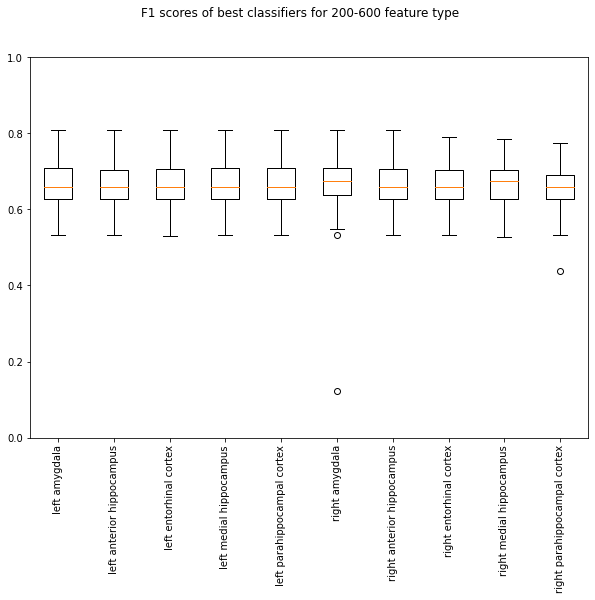

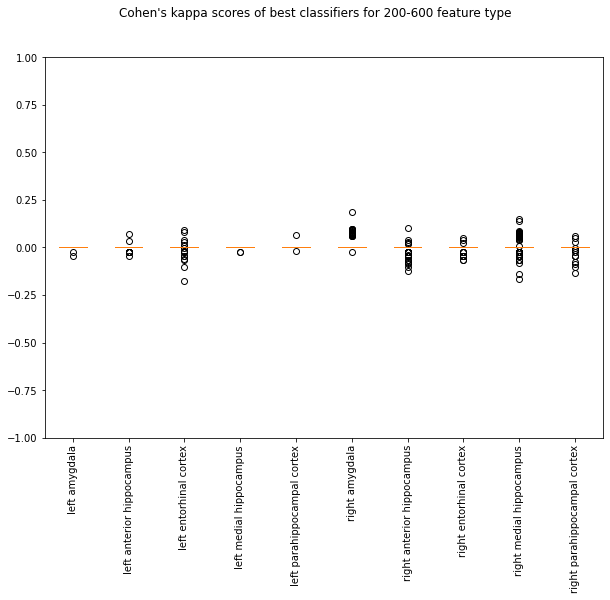

In [17]:
#NEW
#random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-600'

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            #print(for_cols.loc[i,'channel_name'])
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')             
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
        
    for rand_seed in random_seeds:
        np.random.seed(rand_seed) #for train-test split
        strings.append(rand_seed)
        best_params = {}

        # Use a K-fold cross validation with different parameters
        # Create all parameter combinations
        params = {'random_state': [rand_seed],
                  'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                  'loss': ['hinge', 'squared_hinge'],    
                  'penalty': ['l1', 'l2'],
                  #'gamma': ['scale', 'auto'],
                  #'degree': [3]
                 }
        # Create all possible parameter combinations
        combinations_linear = [[i, j, k, l] for i in params['random_state']
                       for j in params['C']
                       for k in params['loss']
                       for l in params ['penalty']]
        for s in reversed(combinations_linear):
            if (s[2] == 'hinge') and (s[3]=='l1'):
                combinations_linear.remove(s)
        combinations = [[i, j] for i in params['random_state']
                       for j in params['C']
                       #for l in params['gamma']
                       #for k in params['degree']
                       ]
        
        for kernel in kernels:
            if kernel == 'linear':
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations_linear, kernel, rand_seed, 'CondensedNN')
            else:
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations, kernel, rand_seed, 'CondensedNN') 
                
            all_losses.append([losses, brain_area])

params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}'
decoding.print_avg_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_precisions_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_recalls_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_f1s_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_kappas_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)

best_clfs = decoding.select_clf_lowest_loss(all_losses, comb_linear, comb_rest, kernels, brain_areas)

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}'
decoding.print_best_clfs_per_area(all_losses, best_clfs, brain_areas, feature_type, movie_stim_percentage, fig_save_path)

brain area: left amygdala
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
loss: 19.67
brain area: left anterior hippocampus
best classifier: [0.0005, 'hinge', 'l2', 'linear']
loss: 19.67
brain area: left entorhinal cortex
best classifier: [0.01, 'hinge', 'l2', 'linear']
loss: 19.66
brain area: left medial hippocampus
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
loss: 19.67
brain area: left parahippocampal cortex
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
loss: 19.67
brain area: right amygdala
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
loss: 19.59
brain area: right anterior hippocampus
best classifier: [0.0001, 'hinge', 'l2', 'linear']
loss: 19.67
brain area: right entorhinal cortex
best classifier: [0.1, 'hinge', 'l2', 'linear']
loss: 19.58
brain area: right medial hippocampus
best classifier: [0.01, 'hinge', 'l2', 'linear']
loss: 19.61
brain area: right parahippocampal cortex
best classifier: [0.001, 'squared_hinge', 'l2', 'linear']
los

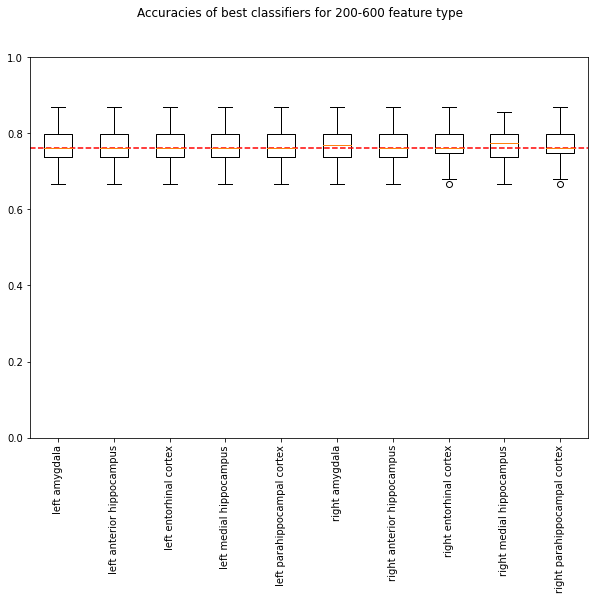

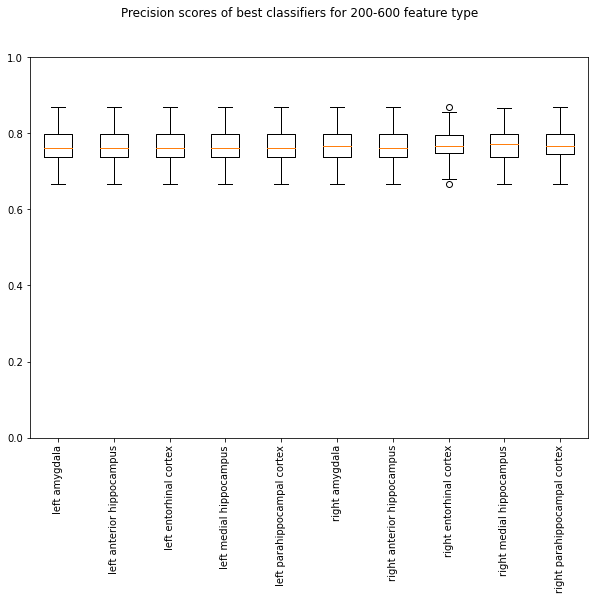

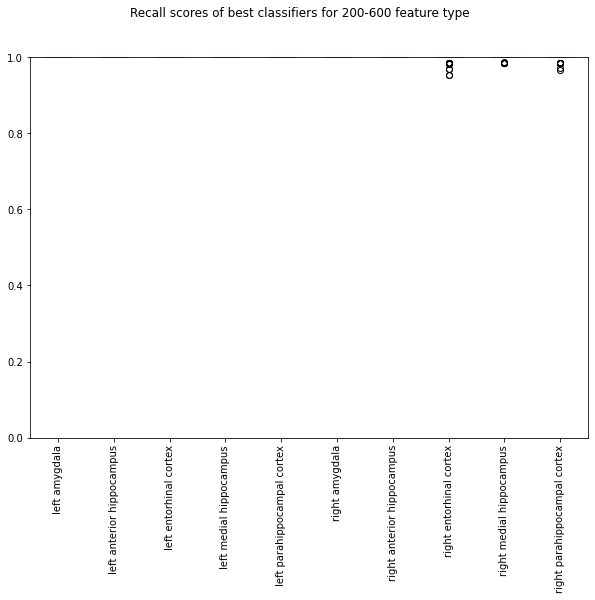

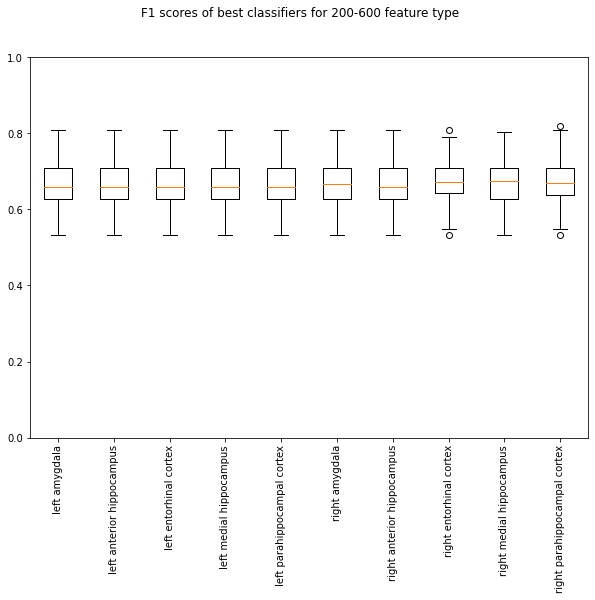

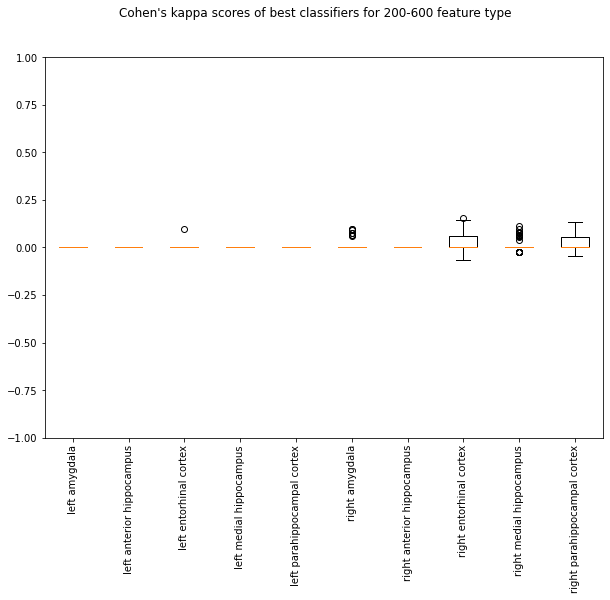

In [7]:
#NEW
#random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-600'

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            #print(for_cols.loc[i,'channel_name'])
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')             
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
        
    for rand_seed in random_seeds:
        np.random.seed(rand_seed) #for train-test split
        strings.append(rand_seed)
        best_params = {}

        # Use a K-fold cross validation with different parameters
        # Create all parameter combinations
        params = {'random_state': [rand_seed],
                  'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                  'loss': ['hinge', 'squared_hinge'],    
                  'penalty': ['l1', 'l2'],
                  #'gamma': ['scale', 'auto'],
                  #'degree': [3]
                 }
        # Create all possible parameter combinations
        combinations_linear = [[i, j, k, l] for i in params['random_state']
                       for j in params['C']
                       for k in params['loss']
                       for l in params ['penalty']]
        for s in reversed(combinations_linear):
            if (s[2] == 'hinge') and (s[3]=='l1'):
                combinations_linear.remove(s)
        combinations = [[i, j] for i in params['random_state']
                       for j in params['C']
                       #for l in params['gamma']
                       #for k in params['degree']
                       ]
        
        for kernel in kernels:
            if kernel == 'linear':
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations_linear, kernel, rand_seed, 'OneSidedSelection')
            else:
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations, kernel, rand_seed, 'OneSidedSelection') 
                
            all_losses.append([losses, brain_area])

params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}'
decoding.print_avg_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_precisions_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_recalls_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_f1s_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_kappas_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)

best_clfs = decoding.select_clf_lowest_loss(all_losses, comb_linear, comb_rest, kernels, brain_areas)

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}'
decoding.print_best_clfs_per_area(all_losses, best_clfs, brain_areas, feature_type, movie_stim_percentage, fig_save_path)

brain area: left amygdala
best classifier: [0.1, 'squared_hinge', 'l1', 'linear']
loss: 19.67
brain area: left anterior hippocampus
best classifier: [0.0005, 'hinge', 'l2', 'linear']
loss: 19.67
brain area: left entorhinal cortex
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
loss: 19.67
brain area: left medial hippocampus
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
loss: 19.67
brain area: left parahippocampal cortex
best classifier: [0.1, 'squared_hinge', 'l1', 'linear']
loss: 19.67
brain area: right amygdala
best classifier: [0.0005, 'hinge', 'l2', 'linear']
loss: 19.67
brain area: right anterior hippocampus
best classifier: [0.0005, 'hinge', 'l2', 'linear']
loss: 19.67
brain area: right entorhinal cortex
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
loss: 19.67
brain area: right medial hippocampus
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
loss: 19.67
brain area: right parahippocampal cortex
best classifier: [0.01, 'squared_hinge', 'l1

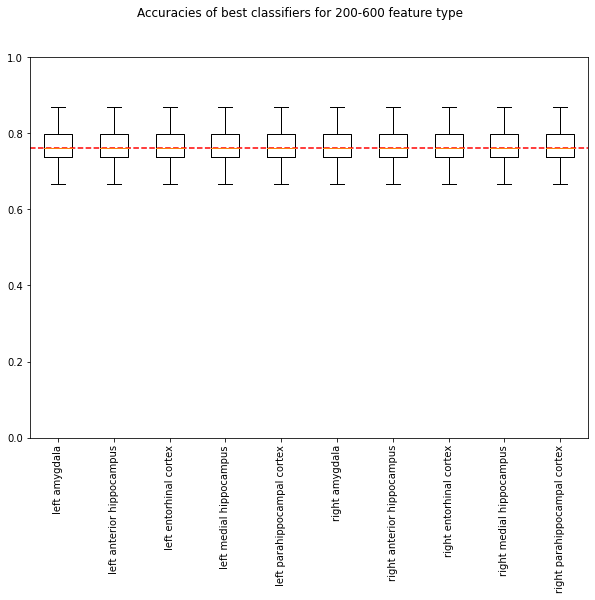

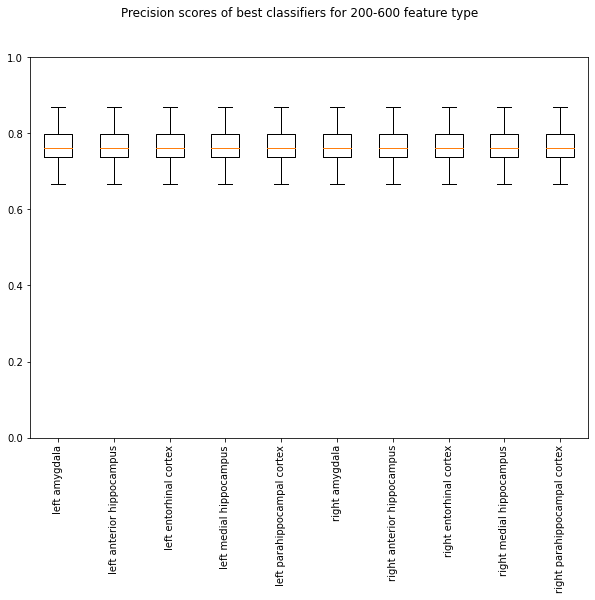

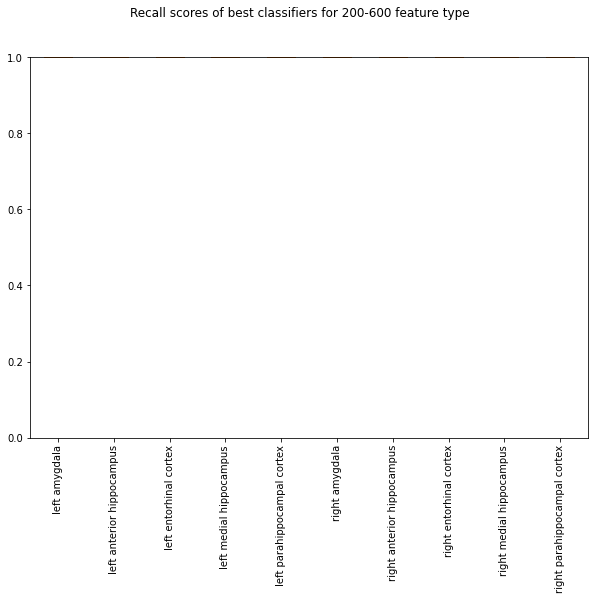

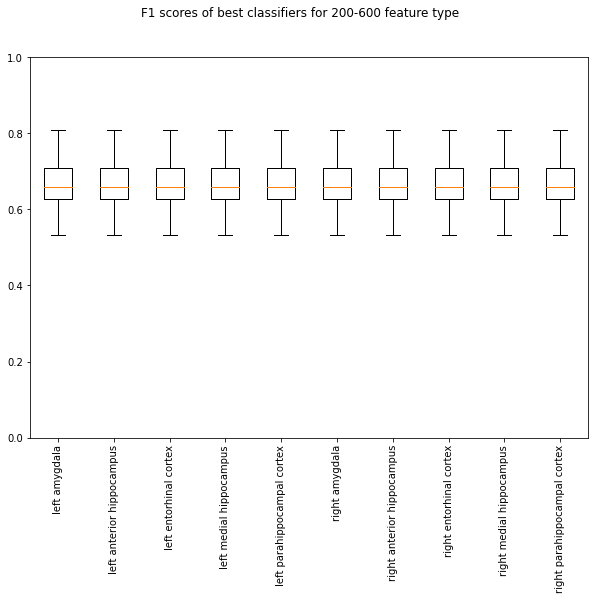

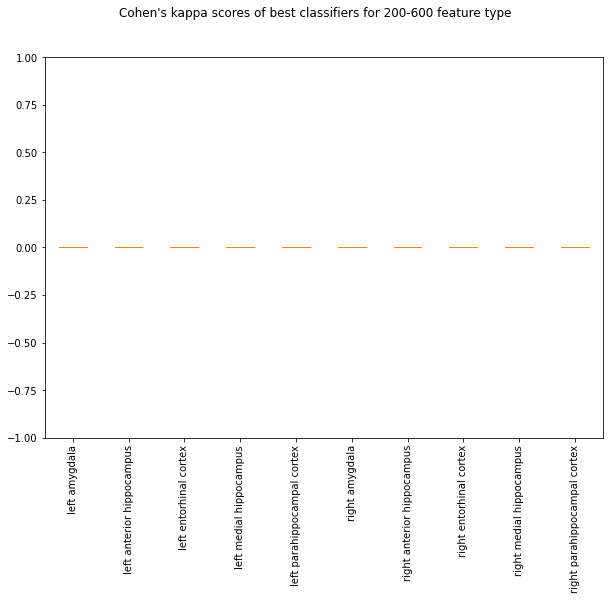

In [8]:
#NEW
#random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-600'

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            #print(for_cols.loc[i,'channel_name'])
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')             
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
        
    for rand_seed in random_seeds:
        np.random.seed(rand_seed) #for train-test split
        strings.append(rand_seed)
        best_params = {}

        # Use a K-fold cross validation with different parameters
        # Create all parameter combinations
        params = {'random_state': [rand_seed],
                  'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                  'loss': ['hinge', 'squared_hinge'],    
                  'penalty': ['l1', 'l2'],
                  #'gamma': ['scale', 'auto'],
                  #'degree': [3]
                 }
        # Create all possible parameter combinations
        combinations_linear = [[i, j, k, l] for i in params['random_state']
                       for j in params['C']
                       for k in params['loss']
                       for l in params ['penalty']]
        for s in reversed(combinations_linear):
            if (s[2] == 'hinge') and (s[3]=='l1'):
                combinations_linear.remove(s)
        combinations = [[i, j] for i in params['random_state']
                       for j in params['C']
                       #for l in params['gamma']
                       #for k in params['degree']
                       ]
        
        for kernel in kernels:
            if kernel == 'linear':
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations_linear, kernel, rand_seed, 'NeighbourhoodCleaningRule')
            else:
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations, kernel, rand_seed, 'NeighbourhoodCleaningRule') 
                
            all_losses.append([losses, brain_area])

params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}'
decoding.print_avg_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_precisions_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_recalls_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_f1s_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_kappas_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)

best_clfs = decoding.select_clf_lowest_loss(all_losses, comb_linear, comb_rest, kernels, brain_areas)

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}'
decoding.print_best_clfs_per_area(all_losses, best_clfs, brain_areas, feature_type, movie_stim_percentage, fig_save_path)

brain area: left amygdala
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
loss: 22.09
brain area: left anterior hippocampus
best classifier: [0.0001, 'hinge', 'l2', 'linear']
loss: 23.72
brain area: left entorhinal cortex
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
loss: 29.97
brain area: left medial hippocampus
best classifier: [0.0001, 'hinge', 'l2', 'linear']
loss: 21.87
brain area: left parahippocampal cortex
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
loss: 20.34
brain area: right amygdala
best classifier: [0.001, 'poly']
loss: 28.33
brain area: right anterior hippocampus
best classifier: [0.1, 'poly']
loss: 34.52
brain area: right entorhinal cortex
best classifier: [0.1, 'poly']
loss: 36.83
brain area: right medial hippocampus
best classifier: [0.0001, 'poly']
loss: 26.46
brain area: right parahippocampal cortex
best classifier: [0.01, 'squared_hinge', 'l1', 'linear']
loss: 35.1
brain area: left amygdala
best classifier: [0.01, 'squared_hinge', 

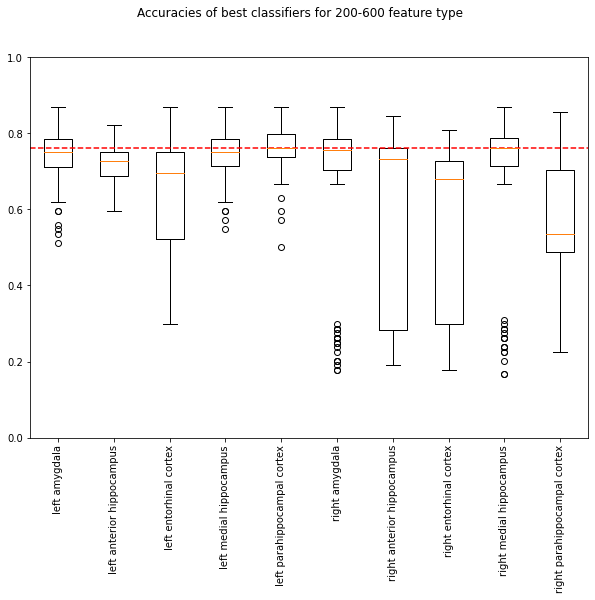

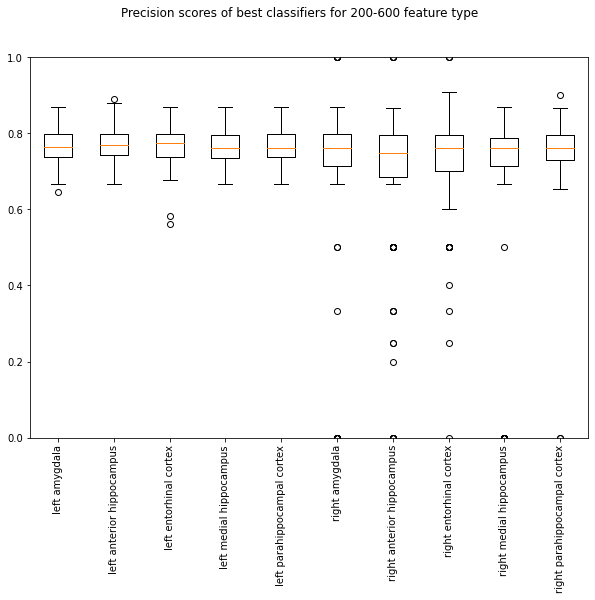

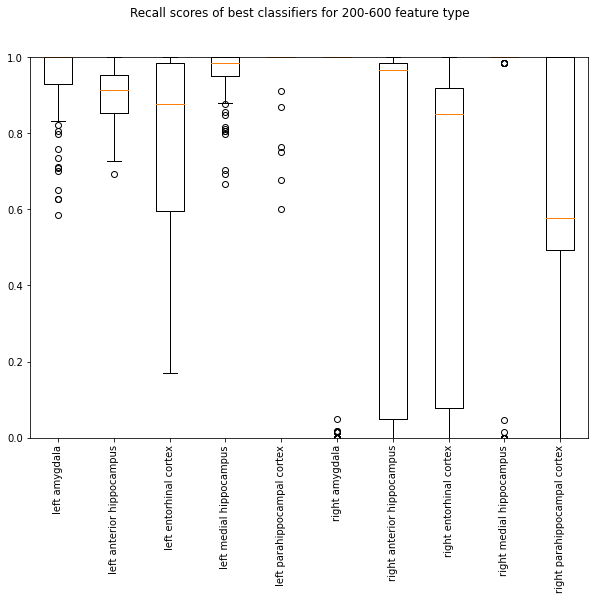

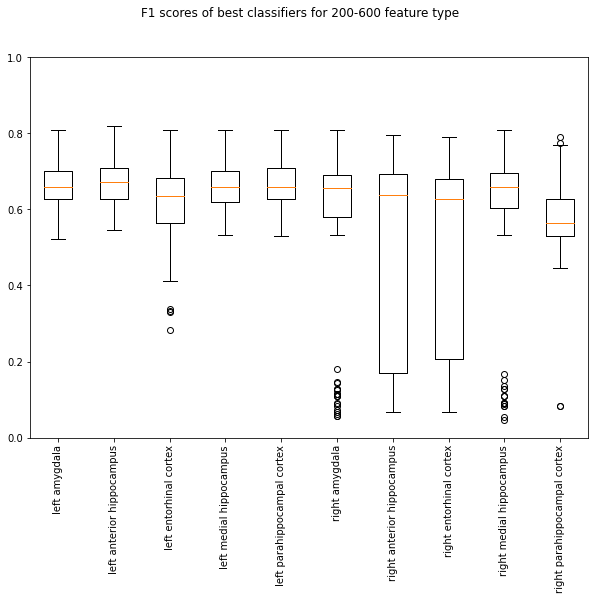

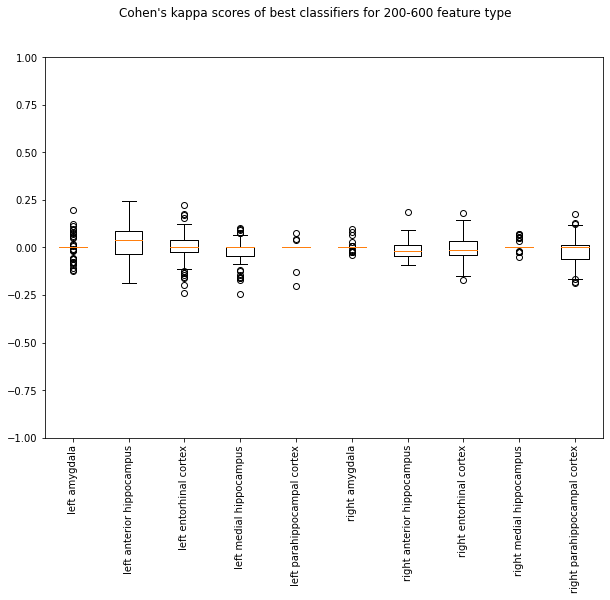

In [9]:
#NEW
#random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-600'

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            #print(for_cols.loc[i,'channel_name'])
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')             
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
        
    for rand_seed in random_seeds:
        np.random.seed(rand_seed) #for train-test split
        strings.append(rand_seed)
        best_params = {}

        # Use a K-fold cross validation with different parameters
        # Create all parameter combinations
        params = {'random_state': [rand_seed],
                  'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                  'loss': ['hinge', 'squared_hinge'],    
                  'penalty': ['l1', 'l2'],
                  #'gamma': ['scale', 'auto'],
                  #'degree': [3]
                 }
        # Create all possible parameter combinations
        combinations_linear = [[i, j, k, l] for i in params['random_state']
                       for j in params['C']
                       for k in params['loss']
                       for l in params ['penalty']]
        for s in reversed(combinations_linear):
            if (s[2] == 'hinge') and (s[3]=='l1'):
                combinations_linear.remove(s)
        combinations = [[i, j] for i in params['random_state']
                       for j in params['C']
                       #for l in params['gamma']
                       #for k in params['degree']
                       ]
        
        for kernel in kernels:
            if kernel == 'linear':
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations_linear, kernel, rand_seed, 'InstanceHardnessThreshold')
            else:
                losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations, kernel, rand_seed, 'InstanceHardnessThreshold') 
                
            all_losses.append([losses, brain_area])

params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}'
decoding.print_avg_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_precisions_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_recalls_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_f1s_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_kappas_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)

best_clfs = decoding.select_clf_lowest_loss(all_losses, comb_linear, comb_rest, kernels, brain_areas)

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}'
decoding.print_best_clfs_per_area(all_losses, best_clfs, brain_areas, feature_type, movie_stim_percentage, fig_save_path)

In [40]:
#OLD
#random_seeds = [1, 10, 42, 86, 100]
random_seeds = [1, 10]
#random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-600'
K=8

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            #print(for_cols.loc[i,'channel_name'])
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600')
            #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')            
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
        
    for rand_seed in random_seeds:
        np.random.seed(rand_seed) #for train-test split
        strings.append(rand_seed)
        best_params = {}

        # Use a K-fold cross validation with different parameters
        # Create all parameter combinations
        params = {'random_state': [rand_seed],
                  'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                  'loss': ['hinge', 'squared_hinge'],    
                  'penalty': ['l1', 'l2'],
                  #'gamma': ['scale', 'auto'],
                  #'degree': [3]
                 }
        # Create all possible parameter combinations
        combinations_linear = [[i, j, k, l] for i in params['random_state']
                       for j in params['C']
                       for k in params['loss']
                       for l in params ['penalty']]
        for s in reversed(combinations_linear):
            if (s[2] == 'hinge') and (s[3]=='l1'):
                combinations_linear.remove(s)
        combinations = [[i, j] for i in params['random_state']
                       for j in params['C']
                       #for l in params['gamma']
                       #for k in params['degree']
                       ]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
        for kernel in kernels:
            losses_best_clf = []
            errors = np.array([])
            strings.append(f'{kernel} classifier')            
            if kernel == 'linear':
                losses, avg_loss, classifier = decoding.custom_SVM(X_train, y_train, K, combinations_linear, kernel, rand_seed)
            else:
                losses, avg_loss, classifier = decoding.custom_SVM(X_train, y_train, K, combinations, kernel, rand_seed)   
            
            best_params = decoding.find_params_with_lowest_loss(avg_loss, kernel)
            string = f'Best parameters for {kernel} classifier: {best_params}'
            strings.append(string)

            if kernel == 'linear':
                if (best_params['penalty']=='l1') and (best_params['loss']=='squared_hinge'):
                    best_params['dual'] = False
                elif (best_params['penalty']=='l2') and (best_params['loss']=='hinge'):
                    best_params['dual'] = True
                else:
                    best_params['dual'] = False
                best_estimator = svm.LinearSVC(**best_params).fit(X_train, y_train)
                cv = CountVectorizer()
                cv.fit(X_train)
                fig = decoding.plot_coefficients(best_estimator, cv.get_feature_names(), top_features=20)
                best_params['kernel'] = kernel
                del best_params['dual']

            else:
                best_params['kernel'] = kernel
                best_estimator = svm.SVC(**best_params).fit(X_train, y_train)
                perm_importance = permutation_importance(best_estimator, X_test, y_test)
                cv = CountVectorizer()
                cv.fit(X_train)
                feature_names = cv.get_feature_names()
                fig = decoding.plot_coefficients_nonlinear(best_estimator, feature_names, X_test, y_test)
            #plt.show()
            fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}/{brain_area}_{kernel}_important_features.png', facecolor='white', transparent=False)
            plt.close()
            
            fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
            y_train_score = best_estimator.decision_function(X_train)
            false_pos_rate, true_pos_rate, _ = roc_curve(y_train, y_train_score)
            roc_auc = auc(false_pos_rate, true_pos_rate)
            cc = best_params['C']
            ax1.plot(false_pos_rate, true_pos_rate, label=f'{kernel} SVM C={cc} ROC curve (area = {roc_auc:.2f})', color='b')
            ax1.set_title('Training Data')

            y_test_score = best_estimator.decision_function(X_test)
            false_pos_rate, true_pos_rate, _ = roc_curve(y_test, y_test_score)
            roc_auc = auc(false_pos_rate, true_pos_rate)
            ax2.plot(false_pos_rate, true_pos_rate, label=f'{kernel} SVM C={cc} ROC curve (area = {roc_auc:.2f})', color='b')
            ax2.set_title('Test Data')
            plt.close()
            
            for ax in fig.axes:
                ax.plot([0, 1], [0, 1], 'k--')
                ax.set_xlim([-0.05, 1.0])
                ax.set_ylim([0.0, 1.05])
                ax.set_xlabel('False Positive Rate')
                ax.set_ylabel('True Positive Rate')
                ax.legend(loc="lower right")
            fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}/{brain_area}_{kernel}_ROC_curve_best.png', facecolor='white', transparent=False)
            #plt.plot()
            plt.close()

            pred = best_estimator.predict(X_test)
            test_error = np.mean(best_estimator.predict(X_test) != y_test)
            train_accuracy = best_estimator.score(X_train, y_train)
            test_accuracy = best_estimator.score(X_test, y_test)
            f1 = f1_score(y_test, pred, average='weighted')
            cm = sklearn.metrics.confusion_matrix(y_test, pred)
            # Model Precision: what percentage of positive tuples are labeled as such?
            precision = sklearn.metrics.precision_score(y_test, pred)
            # Model Recall: what percentage of positive tuples are labelled as such?
            recall = sklearn.metrics.recall_score(y_test, pred)
            #Cohen's Kappa: clf's accuracy normalized by the imbalance of classes
            kappa = sklearn.metrics.cohen_kappa_score(y_test, pred)
                
            string = f'Test error for {kernel} classifier: {test_error}'
            strings.append(string)
            string = f'Train accuracy for {kernel} classifier: {train_accuracy*100}'
            strings.append(string)
            string = f'Test accuracy {kernel} classifier: {test_accuracy*100}'
            strings.append(string)
            string = f'F1 ({kernel} Kernel): {f1*100}'
            strings.append(string)
            string = f'Precision: {precision}'
            strings.append(string)
            string = f'Recall: {recall}'
            strings.append(string)
            strings.append(cm)
            
            loss = np.sum(np.abs(pred - y_test)) 
            errors = np.append(errors, loss)
            
            #all_best_params_list.append(brain_area)
            #all_best_params_list.append(best_params) 
            best_classifier.append([loss, best_params, test_accuracy, f1, cm, precision, recall, kappa])
            del best_params['kernel']
            best_params = list(best_params.values())
            losses_best_clf.append([test_accuracy, loss, f1, cm, precision, recall, kappa, kernel, best_params])
            all_losses.append([losses_best_clf, brain_area])
        all_best_params_list.append([best_classifier, brain_area])
        best_params_clf = decoding.find_classifier_with_lowest_loss(best_classifier)
        best_params_list.append(best_params_clf)

with open(f'{top_dir}/06-decoding_{patient_id}/ovo_movie_vs_nonmovie_{feature_type}.txt', 'w') as f:
    for item in strings:
        f.write("%s\n" % item)
        
        
#open_file = open(f'{top_dir}/06-decoding/best_params_ovo_movie_vs_nonmovie_{feature_type}.pkl', "wb")
#pickle.dump(best_params_list, open_file)
#open_file.close()

params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}'
decoding.print_avg_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_f1s_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_kappas_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)

best_clfs = decoding.select_clf_lowest_loss(all_losses, comb_linear, comb_rest, kernels, brain_areas)

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}'
decoding.print_best_clfs_per_area(all_losses, best_clfs, brain_areas, feature_type, movie_stim_percentage, fig_save_path)

In [73]:
#OLD
random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
#random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-800'
K=8

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[df_patient_info_new['brain_area'].str.contains(brain_area)]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            #print(for_cols.loc[i,'channel_name'])
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_500')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')            
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
        
    for rand_seed in random_seeds:
        np.random.seed(rand_seed) #for train-test split
        strings.append(rand_seed)
        best_params = {}

        # Use a K-fold cross validation with different parameters
        # Create all parameter combinations
        params = {'random_state': [rand_seed],
                  'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                  'loss': ['hinge', 'squared_hinge'],    
                  'penalty': ['l1', 'l2'],
                  #'gamma': ['scale', 'auto'],
                  #'degree': [3]
                 }
        # Create all possible parameter combinations
        combinations_linear = [[i, j, k, l] for i in params['random_state']
                       for j in params['C']
                       for k in params['loss']
                       for l in params ['penalty']]
        for s in reversed(combinations_linear):
            if (s[2] == 'hinge') and (s[3]=='l1'):
                combinations_linear.remove(s)
        combinations = [[i, j] for i in params['random_state']
                       for j in params['C']
                       #for l in params['gamma']
                       #for k in params['degree']
                       ]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
        ros = RandomOverSampler(random_state=0)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
        for kernel in kernels:
            losses_best_clf = []
            errors = np.array([])
            strings.append(f'{kernel} classifier')            
            if kernel == 'linear':
                losses, avg_loss, classifier = decoding.custom_SVM(X_train, y_train, K, combinations_linear, kernel, rand_seed)
            else:
                losses, avg_loss, classifier = decoding.custom_SVM(X_train, y_train, K, combinations, kernel, rand_seed)   
            
            best_params = decoding.find_params_with_lowest_loss(avg_loss, kernel)
            string = f'Best parameters for {kernel} classifier: {best_params}'
            strings.append(string)

            if kernel == 'linear':
                if (best_params['penalty']=='l1') and (best_params['loss']=='squared_hinge'):
                    best_params['dual'] = False
                elif (best_params['penalty']=='l2') and (best_params['loss']=='hinge'):
                    best_params['dual'] = True
                else:
                    best_params['dual'] = False
                best_estimator = svm.LinearSVC(**best_params).fit(X_train, y_train)
                cv = CountVectorizer()
                cv.fit(X_train)
                fig = decoding.plot_coefficients(best_estimator, cv.get_feature_names(), top_features=20)
                best_params['kernel'] = kernel
                del best_params['dual']

            else:
                best_params['kernel'] = kernel
                best_estimator = svm.SVC(**best_params).fit(X_train, y_train)
                perm_importance = permutation_importance(best_estimator, X_test, y_test)
                cv = CountVectorizer()
                cv.fit(X_train)
                feature_names = cv.get_feature_names()
                fig = decoding.plot_coefficients_nonlinear(best_estimator, feature_names, X_test, y_test)
            #plt.show()
            fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}/{brain_area}_{kernel}_important_features.png', facecolor='white', transparent=False)
            plt.close()
            
            fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
            y_train_score = best_estimator.decision_function(X_train)
            false_pos_rate, true_pos_rate, _ = roc_curve(y_train, y_train_score)
            roc_auc = auc(false_pos_rate, true_pos_rate)
            cc = best_params['C']
            ax1.plot(false_pos_rate, true_pos_rate, label=f'{kernel} SVM C={cc} ROC curve (area = {roc_auc:.2f})', color='b')
            ax1.set_title('Training Data')

            y_test_score = best_estimator.decision_function(X_test)
            false_pos_rate, true_pos_rate, _ = roc_curve(y_test, y_test_score)
            roc_auc = auc(false_pos_rate, true_pos_rate)
            ax2.plot(false_pos_rate, true_pos_rate, label=f'{kernel} SVM C={cc} ROC curve (area = {roc_auc:.2f})', color='b')
            ax2.set_title('Test Data')
            plt.close()
            
            for ax in fig.axes:
                ax.plot([0, 1], [0, 1], 'k--')
                ax.set_xlim([-0.05, 1.0])
                ax.set_ylim([0.0, 1.05])
                ax.set_xlabel('False Positive Rate')
                ax.set_ylabel('True Positive Rate')
                ax.legend(loc="lower right")
            fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}/{brain_area}_{kernel}_ROC_curve_best.png', facecolor='white', transparent=False)
            #plt.plot()
            plt.close()

            pred = best_estimator.predict(X_test)
            test_error = np.mean(best_estimator.predict(X_test) != y_test)
            train_accuracy = best_estimator.score(X_train, y_train)
            test_accuracy = best_estimator.score(X_test, y_test)
            f1 = f1_score(y_test, pred, average='weighted')
            cm = sklearn.metrics.confusion_matrix(y_test, pred)
            # Model Precision: what percentage of positive tuples are labeled as such?
            precision = sklearn.metrics.precision_score(y_test, pred)
            # Model Recall: what percentage of positive tuples are labelled as such?
            recall = sklearn.metrics.recall_score(y_test, pred)
            #Cohen's Kappa: clf's accuracy normalized by the imbalance of classes
            kappa = sklearn.metrics.cohen_kappa_score(y_test, pred)
                
            string = f'Test error for {kernel} classifier: {test_error}'
            strings.append(string)
            string = f'Train accuracy for {kernel} classifier: {train_accuracy*100}'
            strings.append(string)
            string = f'Test accuracy {kernel} classifier: {test_accuracy*100}'
            strings.append(string)
            string = f'F1 ({kernel} Kernel): {f1*100}'
            strings.append(string)
            string = f'Precision: {precision}'
            strings.append(string)
            string = f'Recall: {recall}'
            strings.append(string)
            strings.append(cm)
            
            loss = np.sum(np.abs(pred - y_test)) 
            errors = np.append(errors, loss)
            
            #all_best_params_list.append(brain_area)
            #all_best_params_list.append(best_params) 
            best_classifier.append([loss, best_params, test_accuracy, f1, cm, precision, recall, kappa])
            del best_params['kernel']
            best_params = list(best_params.values())
            losses_best_clf.append([test_accuracy, loss, f1, cm, precision, recall, kappa, kernel, best_params])
            all_losses.append([losses_best_clf, brain_area])
        all_best_params_list.append([best_classifier, brain_area])
        best_params_clf = decoding.find_classifier_with_lowest_loss(best_classifier)
        best_params_list.append(best_params_clf)

print(strings)
with open(f'{top_dir}/06-decoding_{patient_id}/ovo_movie_vs_nonmovie_{feature_type}.txt', 'w') as f:
    for item in strings:
        f.write("%s\n" % item)
        
        
#open_file = open(f'{top_dir}/06-decoding/best_params_ovo_movie_vs_nonmovie_{feature_type}.pkl', "wb")
#pickle.dump(best_params_list, open_file)
#open_file.close()


['left amygdala', 1, 'poly classifier', "Best parameters for poly classifier: {'random_state': 1, 'C': 10}", 'Test error for poly classifier: 0.2261904761904762', 'Train accuracy for poly classifier: 81.54761904761905', 'Test accuracy poly classifier: 77.38095238095238', 'F1 (poly Kernel): 74.76789876789877', 'Precision: 0.8266666666666667', 'Recall: 0.9117647058823529', array([[ 3, 13],
       [ 6, 62]]), 'linear classifier', "Best parameters for linear classifier: {'random_state': 1, 'C': 10, 'loss': 'squared_hinge', 'penalty': 'l1'}", 'Test error for linear classifier: 0.21428571428571427', 'Train accuracy for linear classifier: 76.48809523809523', 'Test accuracy linear classifier: 78.57142857142857', 'F1 (linear Kernel): 73.01158301158301', 'Precision: 0.8125', 'Recall: 0.9558823529411765', array([[ 1, 15],
       [ 3, 65]]), 'rbf classifier', "Best parameters for rbf classifier: {'random_state': 1, 'C': 10}", 'Test error for rbf classifier: 0.23809523809523808', 'Train accuracy fo

left amygdala


KeyboardInterrupt: 

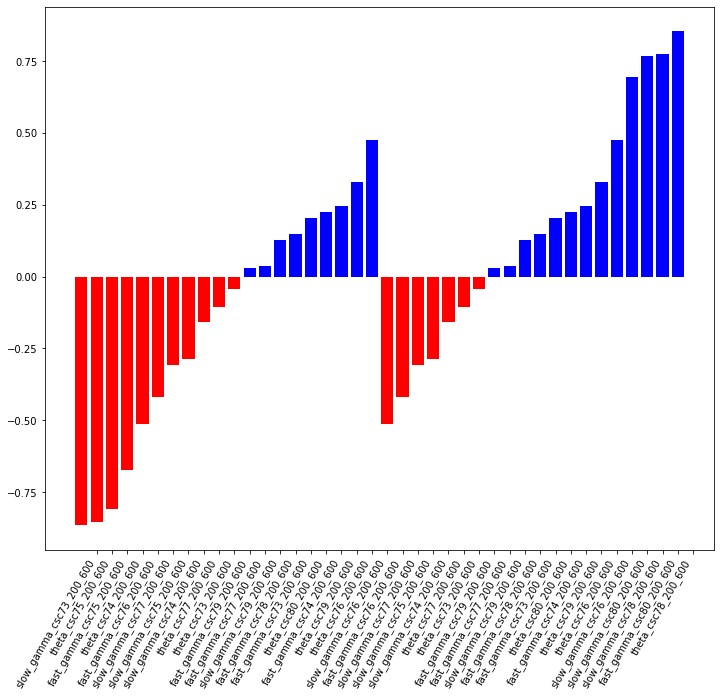

In [19]:
#re-run best classifiers
accuracies = []
random_seeds = np.linspace(1, 500, 100, dtype=int)
for i in range(len(brain_areas)):
    brain_area = brain_areas[i]
    clf = best_clfs[i]
    kernel = clf[-1]
    print(brain_area)
    accuracies_area = []
    for rand_seed in random_seeds:
        np.random.seed(rand_seed) #for train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
        if clf[-1] == 'linear':
            if (clf[2]=='l1') and (clf[1]=='squared_hinge'):
                dual = False
            elif (clf[2]=='l2') and (clf[1]=='hinge'):
                dual = True
            else:
                dual = False
            best_estimator = svm.LinearSVC(penalty=clf[2], loss=clf[1], C=clf[0], dual=dual, random_state=rand_seed).fit(X_train, y_train)
            cv = CountVectorizer()
            cv.fit(X_train)
            fig = decoding.plot_coefficients(best_estimator, cv.get_feature_names(), top_features=20)

        else:
            best_estimator = svm.SVC(C=clf[0], kernel=clf[-1], random_state=rand_seed).fit(X_train, y_train)
            perm_importance = permutation_importance(best_estimator, X_test, y_test)
            cv = CountVectorizer()
            cv.fit(X_train)
            feature_names = cv.get_feature_names()
            fig = decoding.plot_coefficients_nonlinear(best_estimator, feature_names, X_test, y_test)
        #plt.show()
        fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}/{brain_area}_{kernel}_important_features.png', facecolor='white', transparent=False)
        plt.close()

        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
        y_train_score = best_estimator.decision_function(X_train)
        false_pos_rate, true_pos_rate, _ = roc_curve(y_train, y_train_score)
        roc_auc = auc(false_pos_rate, true_pos_rate)
        cc = clf[0]
        ax1.plot(false_pos_rate, true_pos_rate, label=f'{kernel} SVM C={cc} ROC curve (area = {roc_auc:.2f})', color='b')
        ax1.set_title('Training Data')

        y_test_score = best_estimator.decision_function(X_test)
        false_pos_rate, true_pos_rate, _ = roc_curve(y_test, y_test_score)
        roc_auc = auc(false_pos_rate, true_pos_rate)
        ax2.plot(false_pos_rate, true_pos_rate, label=f'{kernel} SVM C={cc} ROC curve (area = {roc_auc:.2f})', color='b')
        ax2.set_title('Test Data')
        plt.close()

        for ax in fig.axes:
            ax.plot([0, 1], [0, 1], 'k--')
            ax.set_xlim([-0.05, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.legend(loc="lower right")
        fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}/{brain_area}_{kernel}_ROC_curve_best.png', facecolor='white', transparent=False)
        #plt.plot()
        plt.close()

        pred = best_estimator.predict(X_test)
        test_error = np.mean(best_estimator.predict(X_test) != y_test)
        train_accuracy = best_estimator.score(X_train, y_train)
        test_accuracy = best_estimator.score(X_test, y_test)
        f1 = f1_score(y_test, pred, average='weighted')
        cm = sklearn.metrics.confusion_matrix(y_test, pred)
        # Model Precision: what percentage of positive tuples are labeled as such?
        precision = sklearn.metrics.precision_score(y_test, pred)
        # Model Recall: what percentage of positive tuples are labelled as such?
        recall = sklearn.metrics.recall_score(y_test, pred)

        string = f'Test error for {kernel} classifier: {test_error}'
        #print(string)
        strings.append(string)
        string = f'Train accuracy for {kernel} classifier: {train_accuracy*100}'
        #print(string)
        strings.append(string)
        string = f'Test accuracy {kernel} classifier: {test_accuracy*100}'
        #print(string)
        strings.append(string)
        string = f'F1 ({kernel} Kernel): {f1*100}'
        #print(string)
        strings.append(string)
        string = f'Precision: {precision}'
        #print(string)
        strings.append(string)
        string = f'Recall: {recall}'
        #print(string)
        strings.append(string)            
        #print(cm)
        strings.append(cm)
        accuracies_area.append(test_accuracy)
    accuracies.append(accuracies_area)

#accuracies of best classifiers per area
mean_accuracies = []
std_accuracies = []
for i in range(len(brain_areas)):
    acc = accuracies[i]
    mean_accuracies.append(np.mean(acc))
    std_accuracies.append(np.std(acc))

#plot
fig = plt.figure(figsize =(10, 7))
string = f'Accuracies of best classifiers for {feature_type} feature type'
fig.suptitle(string)
# Creating plot
plt.boxplot(accuracies, labels=brain_areas)
plt.ylim(0,1)
plt.axhline(movie_stim_percentage/100, c='r', linestyle='--')
plt.xticks(rotation=90)
plt.show()
fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots_best/Accuracies of best classifiers for {feature_type} feature type.png',facecolor='white', transparent=False)